# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from src.lightgbm_wrapper.feature_engineer import add_time_features, add_lag_features, add_rolling_features
from src.lightgbm_wrapper.station_embedding import learn_station_embeddings, attach_station_embedding
from src.lightgbm_wrapper.plot import plot_1_data, plot_2_data
from src.lightgbm_wrapper.model import build_supervised_for_horizon, train_test_validation_split, train_lgbm_for_horizon, plot_timeseries_example

try:
    import lightgbm as lgb
except:
    print("lightgbm is not installed")

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"
STATION_IDS = [211, 212, 213, 214, 215, 216]

CMAQDATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station"

PM_COLS = [
    "NO2_quantrac",
    "PM25_quantrac",
    "O3_quantrac",
    "CO_quantrac",
    "Temperature_quantrac",
    "Humid_quantrac",
]

CMAQ_COLS = [
    "NO2_cmaq",
    "O3_cmaq",
    "SO2_cmaq"
]

BASE_FEATURE_COLS = PM_COLS + CMAQ_COLS

# Define lag and rolling windows for feature engineering
LAG_STEPS = [3, 6, 12, 24, 48, 72]
ROLL_WINDOWS = [3, 6, 12, 24, 48, 72]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

RANDOM_STATE = 42

model_path = "/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/no2_o3_co_pmcmaqdata_test_models"

# Load dataset

## Method

In [2]:
def load_station_csv(station_id, data_dir=DATA_DIR):
    csv_path = os.path.join(data_dir, f"{station_id}.csv")
    df = pd.read_csv(csv_path)

    # Convert to datetime
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
    elif "Date" in df.columns and "Time" in df.columns:
        df["date"] = pd.to_datetime((df["Date"] + " " + df["Time"]).astype('datetime64[ns]'), format="%y/%m/%d %H:%M:%S")
        df = df.drop(columns=["Date", "Time"])
    df = df.sort_values("date").reset_index(drop=True)

    # Remove "Unnamed" column
    for c in df.columns:
        if "Unnamed:" in c:
            df = df.drop(columns=[c])

    # Add station_id column
    if "Station" not in df.columns:
        df["station_id"] = station_id
    else:
        df = df.rename({"Station": "station_id"}, axis=1)
    return df

## CMAQ data

In [3]:
# Load dataset
dfs_cmaq = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, CMAQDATA_DIR)
    dfs_cmaq.append(df_sid)
df_cmaq = pd.concat(dfs_cmaq, ignore_index=True)

# Rename columns
df_cmaq = df_cmaq.rename({c: f"{c}_cmaq" for c in df_cmaq.columns if c not in ["date", "station_id"]}, axis=1)

# Sort data by station then date
df_cmaq = df_cmaq.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_cmaq = df_cmaq.loc[:, ["date"] + CMAQ_COLS + ["station_id"]]

display(df_cmaq)

# Convert unit
df_cmaq["NO2_cmaq"] = df_cmaq["NO2_cmaq"] * 1883.2
df_cmaq["O3_cmaq"] = df_cmaq["O3_cmaq"] * 1960
df_cmaq["SO2_cmaq"] = df_cmaq["SO2_cmaq"] * 2620

print(df_cmaq.shape)
print(df_cmaq.columns)
df_cmaq

date  NO2_cmaq   O3_cmaq  SO2_cmaq  station_id
0     2022-01-01 07:00:00  0.000072  0.096425  0.000027         211
1     2022-01-01 08:00:00  0.000074  0.077419  0.000038         211
2     2022-01-01 09:00:00  0.000055  0.061006  0.000050         211
3     2022-01-01 10:00:00  0.000040  0.048525  0.000057         211
4     2022-01-01 11:00:00  0.000034  0.029449  0.000047         211
...                   ...       ...       ...       ...         ...
44851 2022-12-31 01:00:00  0.002276  0.026421  0.000149         216
44852 2022-12-31 02:00:00  0.002208  0.026171  0.000148         216
44853 2022-12-31 03:00:00  0.002249  0.026087  0.000151         216
44854 2022-12-31 04:00:00  0.002680  0.026347  0.000166         216
44855 2022-12-31 05:00:00  0.002590  0.026102  0.000164         216

[44856 rows x 5 columns]

(44856, 5)
Index(['date', 'NO2_cmaq', 'O3_cmaq', 'SO2_cmaq', 'station_id'], dtype='object')


date  NO2_cmaq     O3_cmaq  SO2_cmaq  station_id
0     2022-01-01 07:00:00  0.136344  188.993157  0.071526         211
1     2022-01-01 08:00:00  0.138604  151.741122  0.100084         211
2     2022-01-01 09:00:00  0.104141  119.571595  0.130476         211
3     2022-01-01 10:00:00  0.075893   95.109490  0.149078         211
4     2022-01-01 11:00:00  0.063087   57.721016  0.122092         211
...                   ...       ...         ...       ...         ...
44851 2022-12-31 01:00:00  4.285888   51.784937  0.389183         216
44852 2022-12-31 02:00:00  4.157322   51.295325  0.386550         216
44853 2022-12-31 03:00:00  4.235773   51.130547  0.394695         216
44854 2022-12-31 04:00:00  5.047855   51.640614  0.435544         216
44855 2022-12-31 05:00:00  4.876919   51.160312  0.429932         216

[44856 rows x 5 columns]

## PM data

In [4]:
# Load dataset
dfs_pm = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, DATA_DIR)
    dfs_pm.append(df_sid)
df_pm = pd.concat(dfs_pm, ignore_index=True)

# Sort data by station then date
df_pm = df_pm.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_pm = df_pm.loc[:, ["date"] + PM_COLS + ["station_id"]]

print(df_pm.shape)
print(df_pm.columns)
df_pm

(92966, 8)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'station_id'],
      dtype='object')


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2021-02-23 21:00:00    112.740762      15.604762    55.431381   
1     2021-02-23 22:00:00    112.366471      14.594118    58.197176   
2     2021-02-23 23:00:00    112.700433      13.436667    55.029433   
3     2021-02-24 00:00:00    112.480867      12.365000    54.767700   
4     2021-02-24 01:00:00    114.331500      11.636667    53.786200   
...                   ...           ...            ...          ...   
92961 2022-12-31 19:00:00      0.088233      41.450000    75.916667   
92962 2022-12-31 20:00:00      0.083217      50.530000    66.116667   
92963 2022-12-31 21:00:00      0.084300      55.055000    55.133333   
92964 2022-12-31 22:00:00      0.066650      26.078333    46.750000   
92965 2022-12-31 23:00:00      0.067783      21.161667    50.016667   

       CO_quantrac  Temperature_quantrac  Humid_quantrac  station_id  
0        90.000000             28.361905       63.188095         211  
1      1200.603529             28.320588       63.773529         211  
2      1177.897000             28.336667       64.205000         211  
3        90.000000             28.305000       64.735000         211  
4        90.000000             28.300000       65.188333         211  
...            ...                   ...             ...         ...  
92961     2.087167             27.690000       67.290000         216  
92962     2.006500             27.401667       68.026667         216  
92963     2.418833             27.603333       66.965000         216  
92964     1.481500             27.036667       63.361667         216  
92965     1.301167             26.358333       63.343333         216  

[92966 rows x 8 columns]

## Merge 2 data

In [5]:
dfs_all = []
for station in STATION_IDS:
    df_pm_station = df_pm[df_pm["station_id"] == station]
    df_cmaq_station = df_cmaq[df_cmaq["station_id"] == station]
    df_joined = pd.merge(df_pm_station.drop(columns=["station_id"]), df_cmaq_station, on='date', how='inner')
    dfs_all.append(df_joined)
df_all = pd.concat(dfs_all, axis=0).reset_index(drop=True)
df_all

date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0     2022-01-01 07:00:00     90.000000      22.783333    35.588975   
1     2022-01-01 08:00:00     90.000000      21.883333    55.011077   
2     2022-01-01 09:00:00     90.000000      16.233333    64.729197   
3     2022-01-01 10:00:00     90.000000      15.700000    75.109218   
4     2022-01-01 11:00:00     74.207348      15.650000    77.767804   
...                   ...           ...            ...          ...   
43370 2022-12-31 01:00:00      0.049037      17.709259    31.425926   
43371 2022-12-31 02:00:00      0.063288      22.803390    43.220339   
43372 2022-12-31 03:00:00      0.069050      23.031667    48.866667   
43373 2022-12-31 04:00:00      0.064600      22.331667    50.633333   
43374 2022-12-31 05:00:00      0.064517      20.108333    52.333333   

       CO_quantrac  Temperature_quantrac  Humid_quantrac  NO2_cmaq  \
0       756.627400             24.661667       73.355000  0.136344   
1       749.102000             27.258333       65.521667  0.138604   
2       727.519000             29.250000       57.910000  0.104141   
3       721.196900             30.676667       53.673333  0.075893   
4       722.056400             32.168333       49.080000  0.063087   
...            ...                   ...             ...       ...   
43370     0.824074             26.659259       64.601852  4.285888   
43371     0.717627             25.771186       66.067797  4.157322   
43372     0.746167             25.178333       68.278333  4.235773   
43373     0.617667             24.950000       68.225000  5.047855   
43374     0.621500             24.585000       67.740000  4.876919   

          O3_cmaq  SO2_cmaq  station_id  
0      188.993157  0.071526         211  
1      151.741122  0.100084         211  
2      119.571595  0.130476         211  
3       95.109490  0.149078         211  
4       57.721016  0.122092         211  
...           ...       ...         ...  
43370   51.784937  0.389183         216  
43371   51.295325  0.386550         216  
43372   51.130547  0.394695         216  
43373   51.640614  0.435544         216  
43374   51.160312  0.429932         216  

[43375 rows x 11 columns]

In [6]:
df_all.isnull().sum()

date                        0
NO2_quantrac            27391
PM25_quantrac           27393
O3_quantrac             30277
CO_quantrac             27407
Temperature_quantrac    35140
Humid_quantrac          35140
NO2_cmaq                    0
O3_cmaq                     0
SO2_cmaq                    0
station_id                  0
dtype: int64

# Data preparation

## Drop missing

Output: df_dropped

In [7]:
df_dropped = df_all.dropna().reset_index(drop=True)
df_dropped

date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0    2022-01-01 07:00:00     90.000000      22.783333    35.588975   
1    2022-01-01 08:00:00     90.000000      21.883333    55.011077   
2    2022-01-01 09:00:00     90.000000      16.233333    64.729197   
3    2022-01-01 10:00:00     90.000000      15.700000    75.109218   
4    2022-01-01 11:00:00     74.207348      15.650000    77.767804   
...                  ...           ...            ...          ...   
8228 2022-12-31 01:00:00      0.049037      17.709259    31.425926   
8229 2022-12-31 02:00:00      0.063288      22.803390    43.220339   
8230 2022-12-31 03:00:00      0.069050      23.031667    48.866667   
8231 2022-12-31 04:00:00      0.064600      22.331667    50.633333   
8232 2022-12-31 05:00:00      0.064517      20.108333    52.333333   

      CO_quantrac  Temperature_quantrac  Humid_quantrac  NO2_cmaq     O3_cmaq  \
0      756.627400             24.661667       73.355000  0.136344  188.993157   
1      749.102000             27.258333       65.521667  0.138604  151.741122   
2      727.519000             29.250000       57.910000  0.104141  119.571595   
3      721.196900             30.676667       53.673333  0.075893   95.109490   
4      722.056400             32.168333       49.080000  0.063087   57.721016   
...           ...                   ...             ...       ...         ...   
8228     0.824074             26.659259       64.601852  4.285888   51.784937   
8229     0.717627             25.771186       66.067797  4.157322   51.295325   
8230     0.746167             25.178333       68.278333  4.235773   51.130547   
8231     0.617667             24.950000       68.225000  5.047855   51.640614   
8232     0.621500             24.585000       67.740000  4.876919   51.160312   

      SO2_cmaq  station_id  
0     0.071526         211  
1     0.100084         211  
2     0.130476         211  
3     0.149078         211  
4     0.122092         211  
...        ...         ...  
8228  0.389183         216  
8229  0.386550         216  
8230  0.394695         216  
8231  0.435544         216  
8232  0.429932         216  

[8233 rows x 11 columns]

## Update the STATION_IDS after dropping missing

In [8]:
STATION_IDS = list(df_dropped["station_id"].unique())
STATION_IDS

[211, 212, 213, 216]

## Visualization

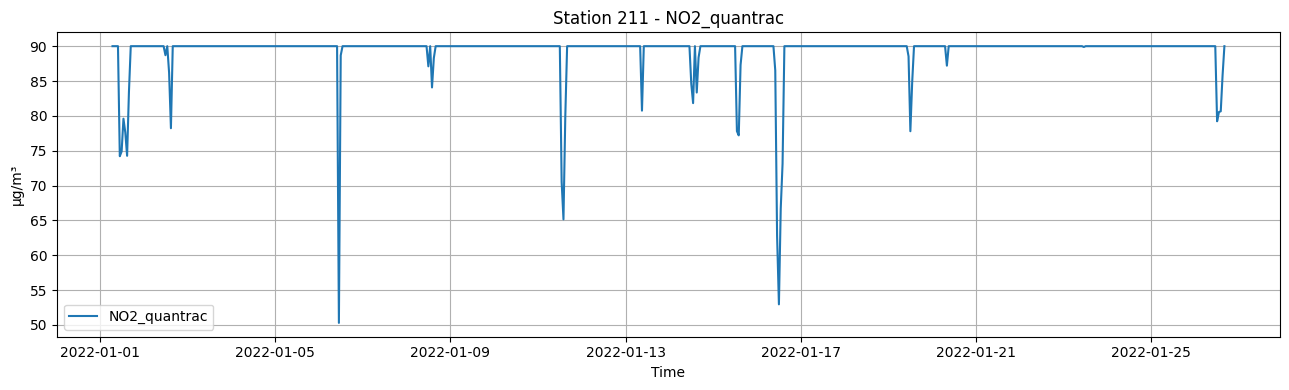

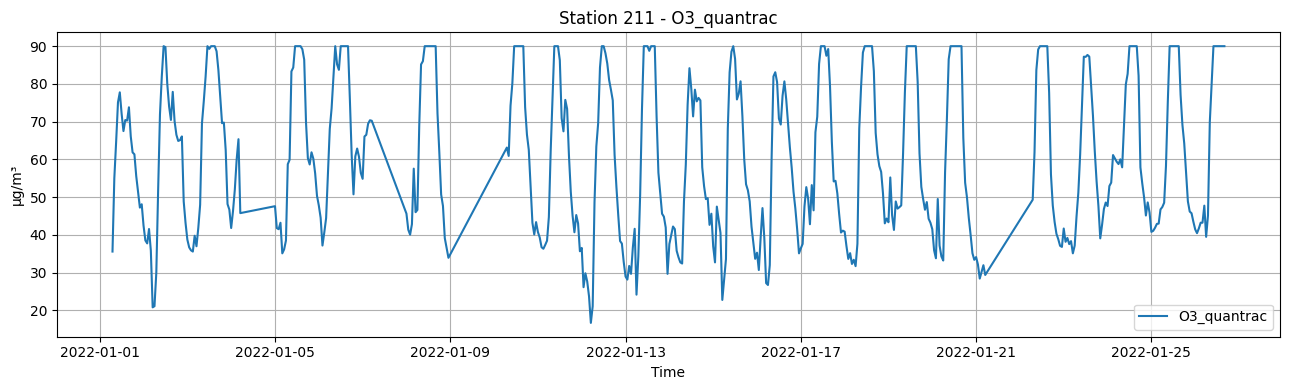

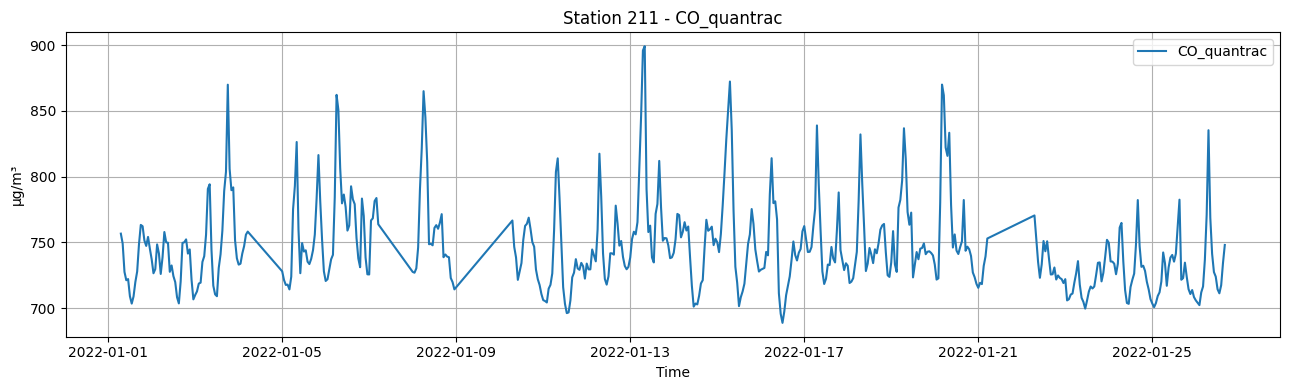

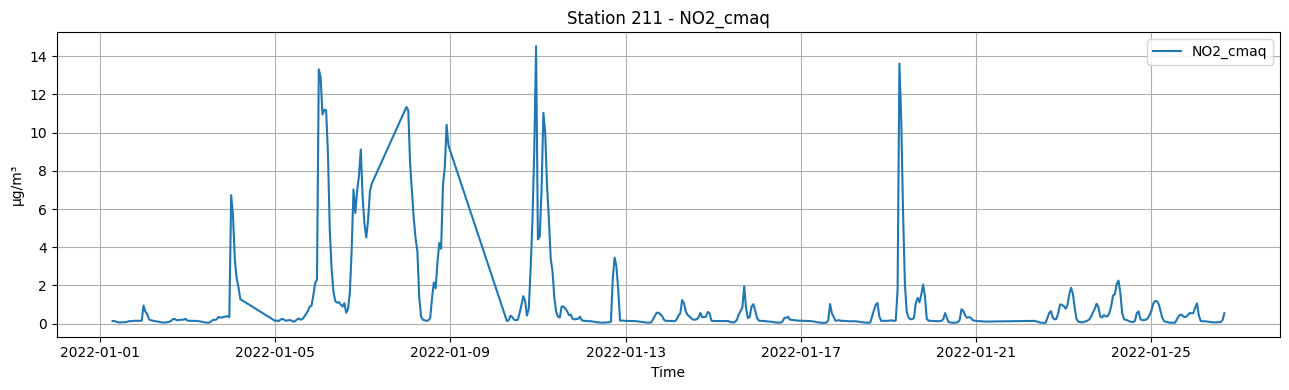

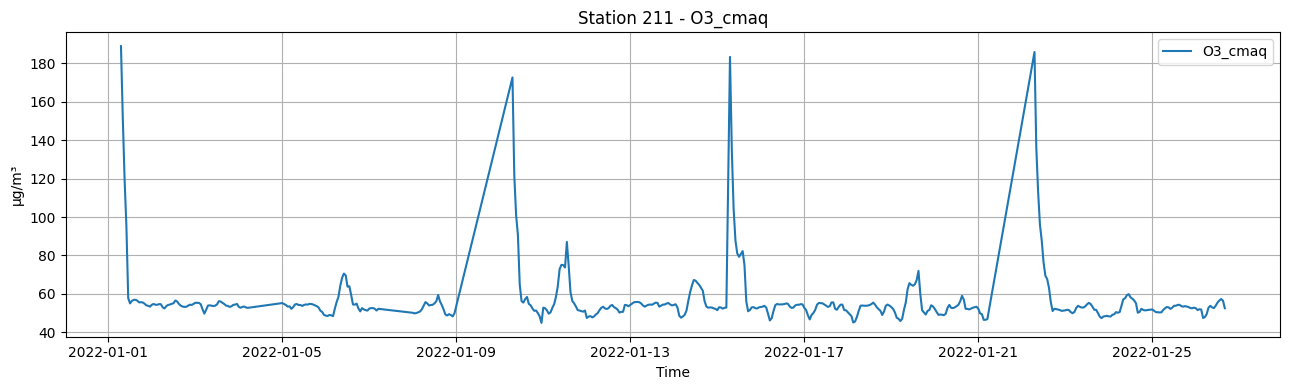

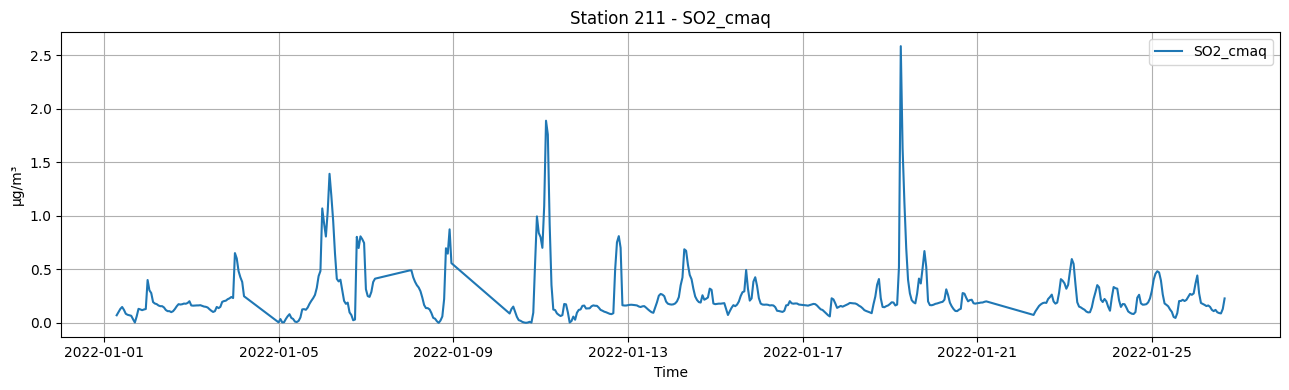

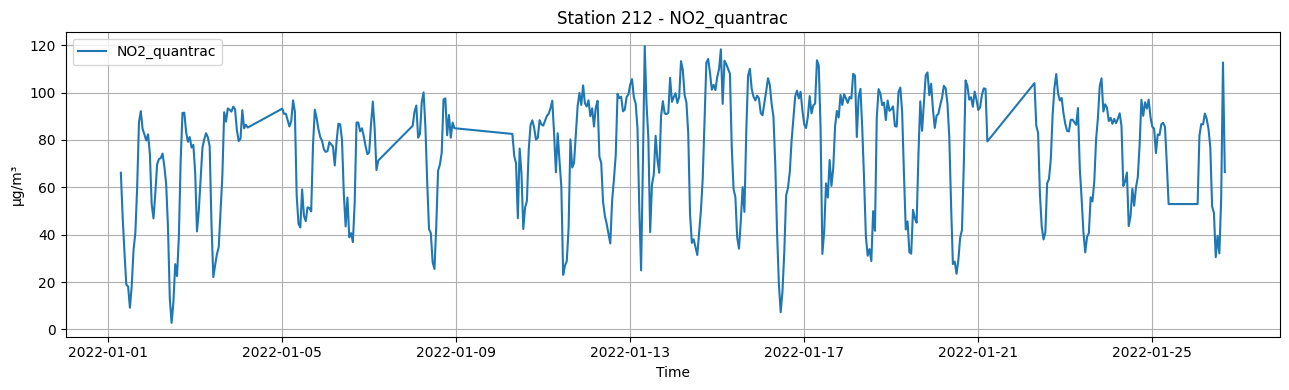

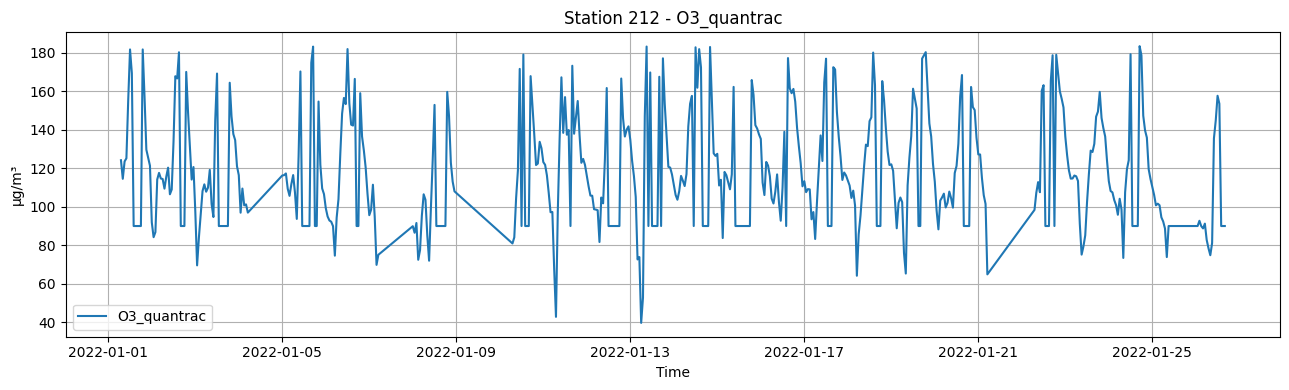

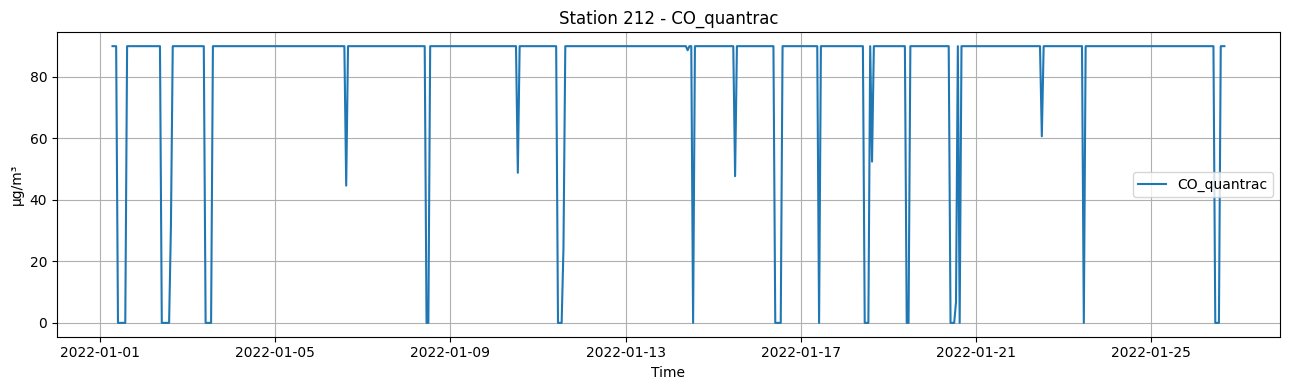

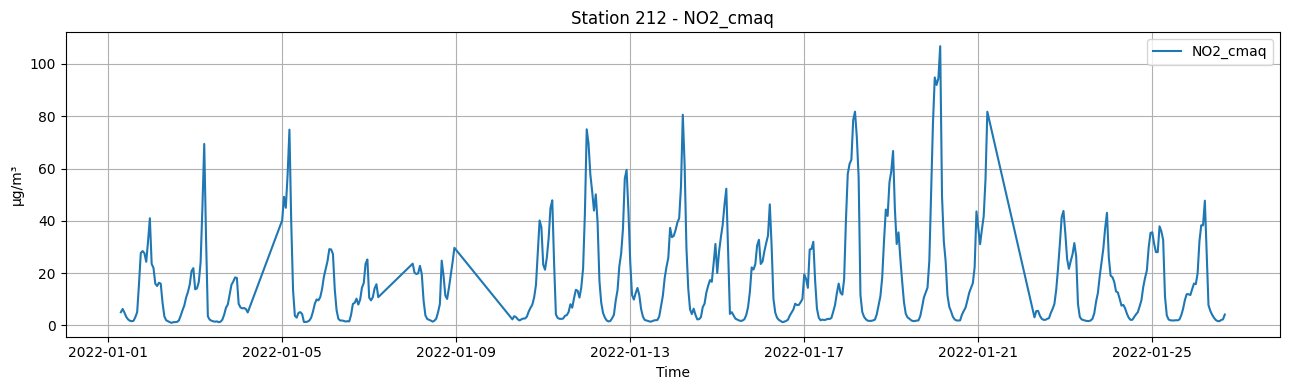

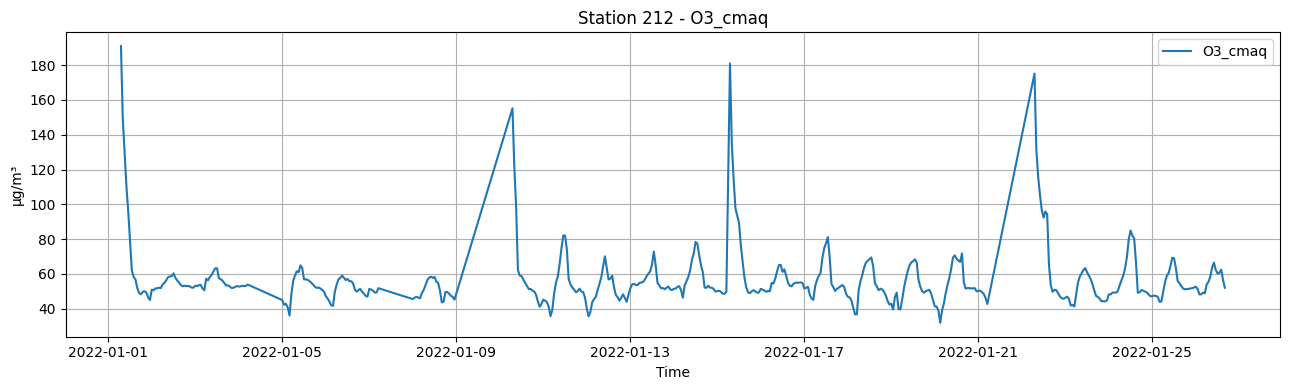

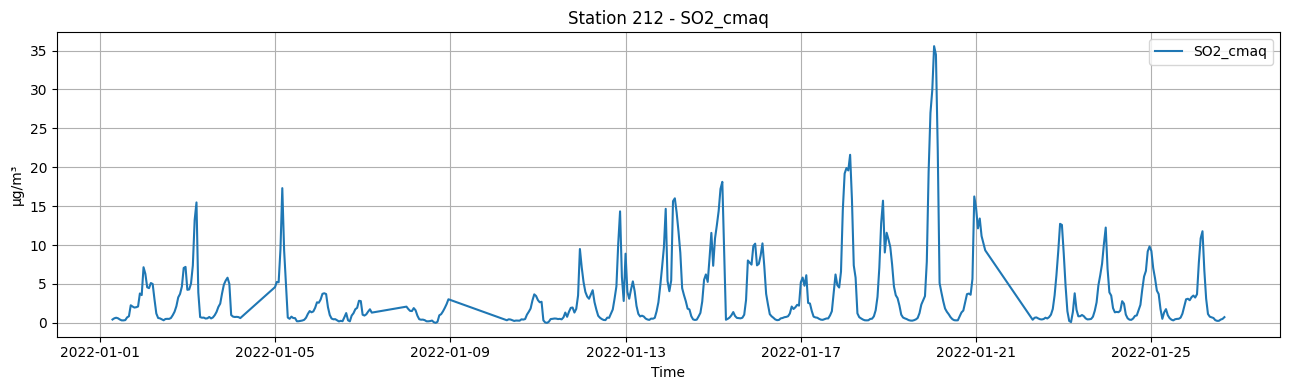

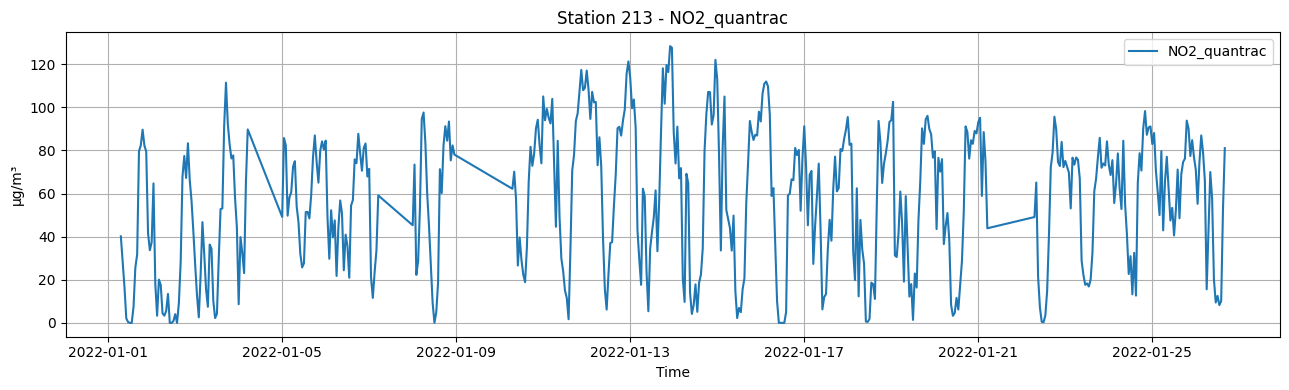

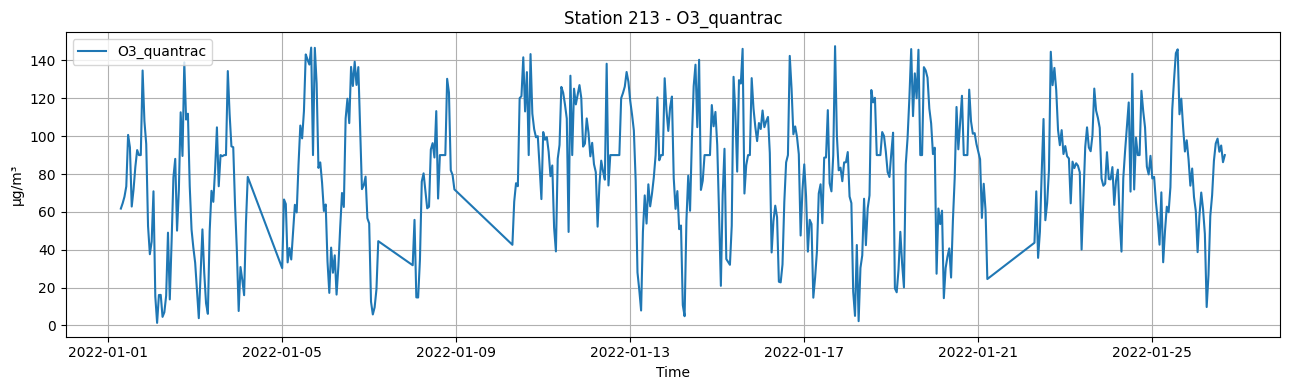

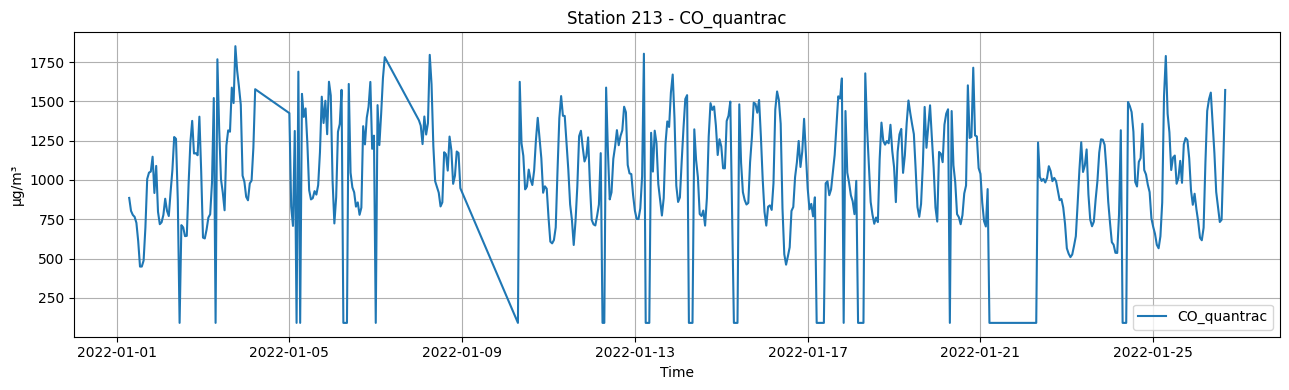

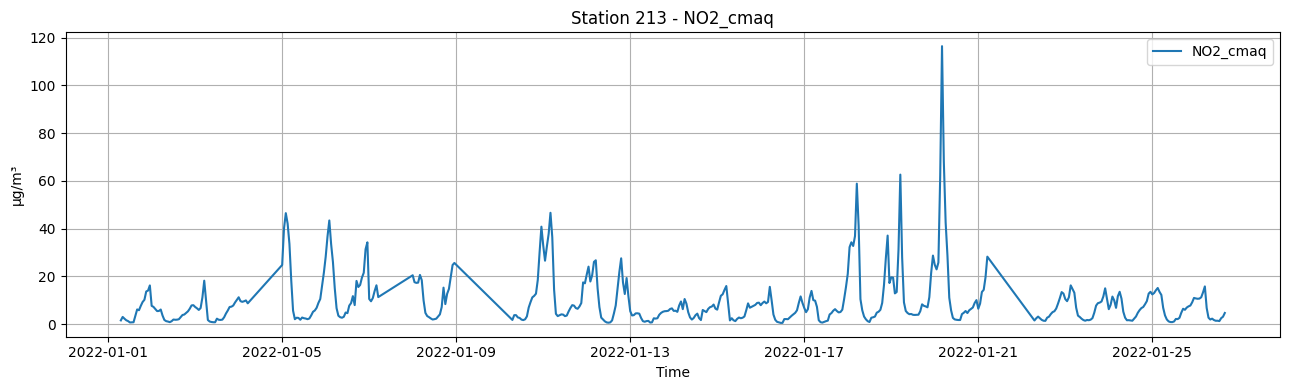

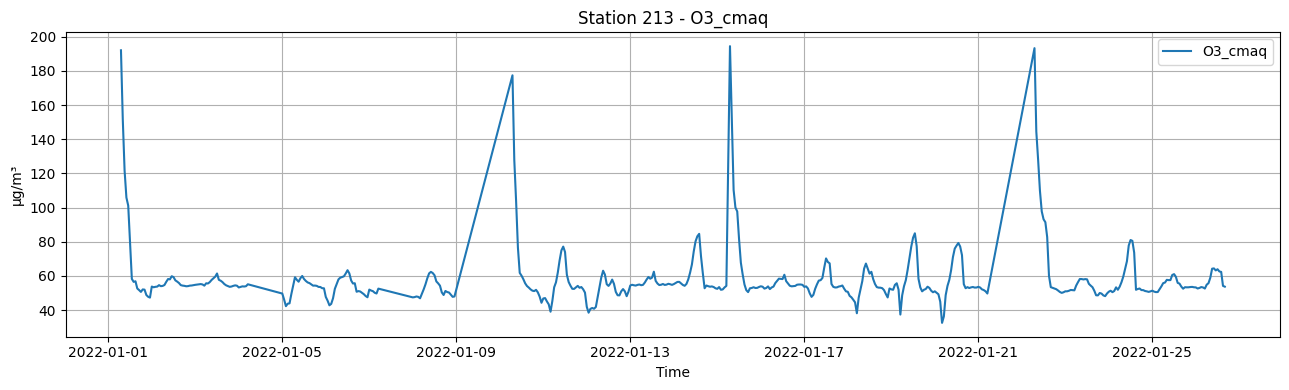

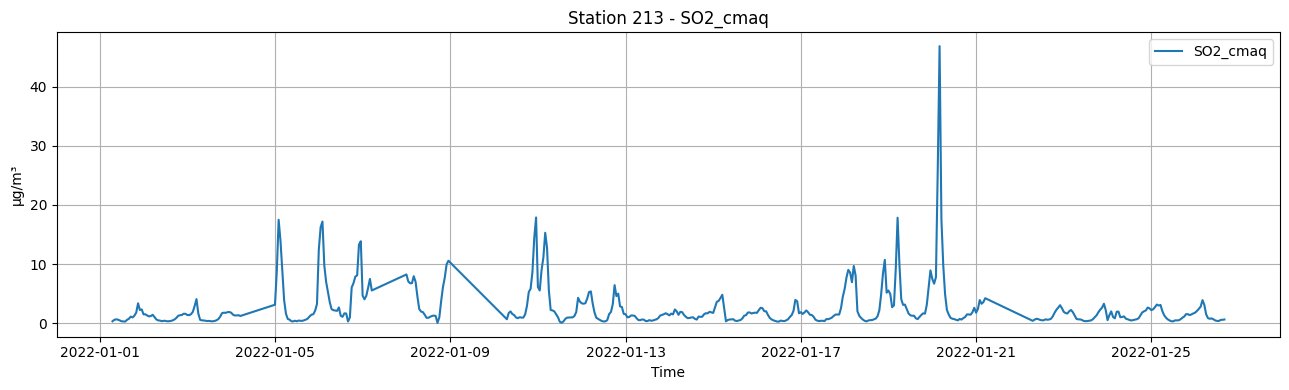

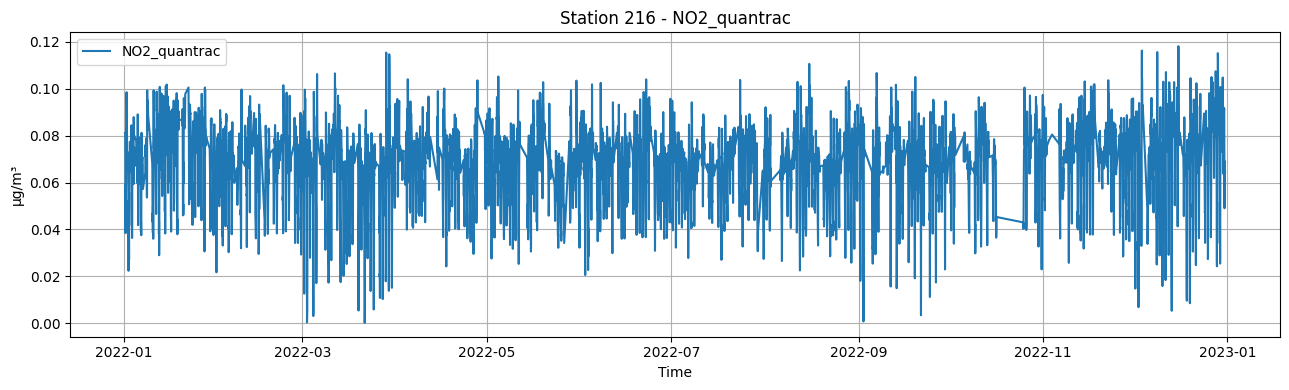

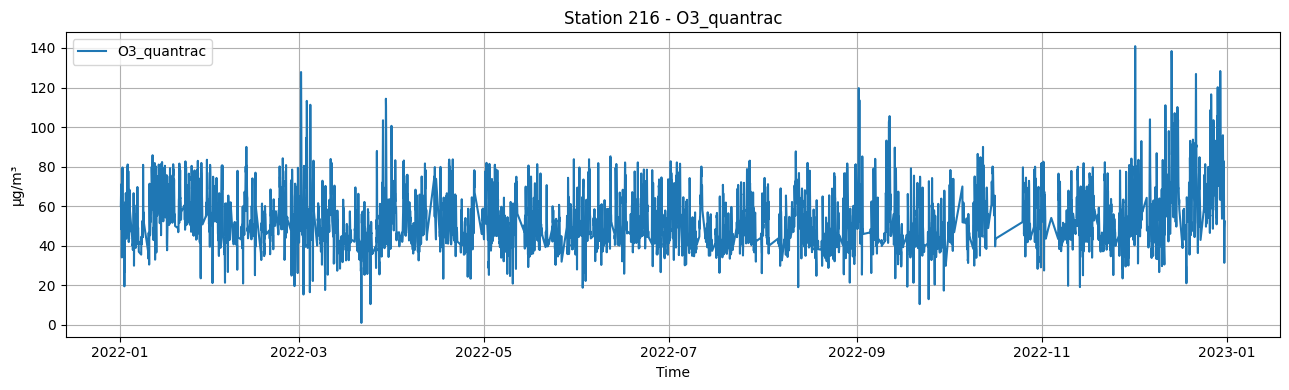

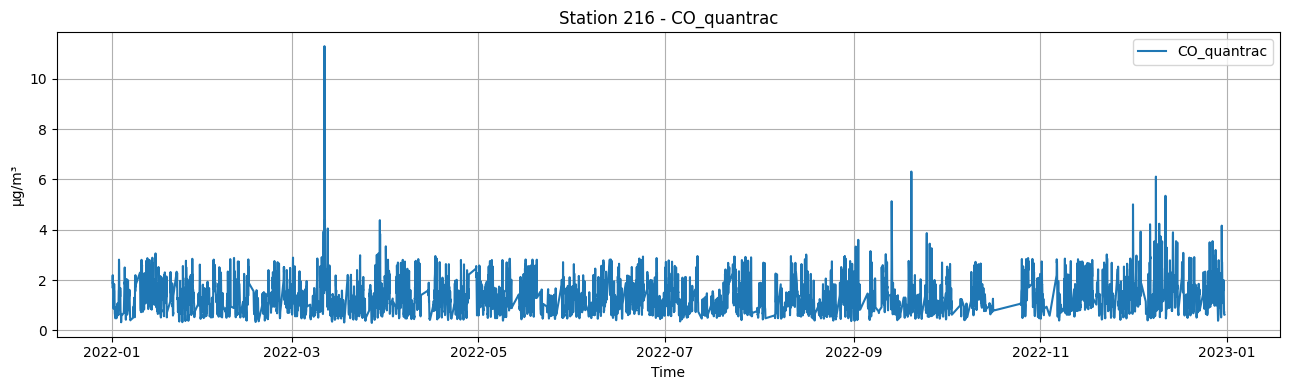

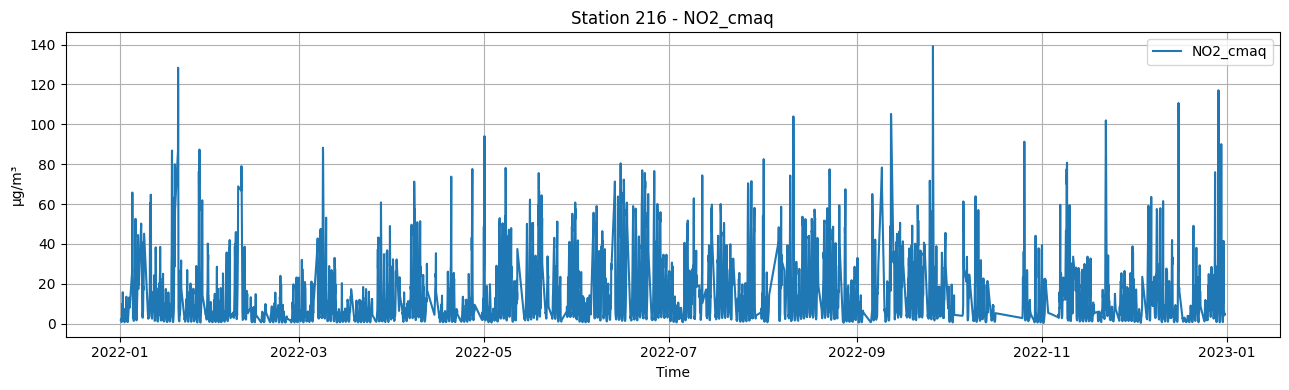

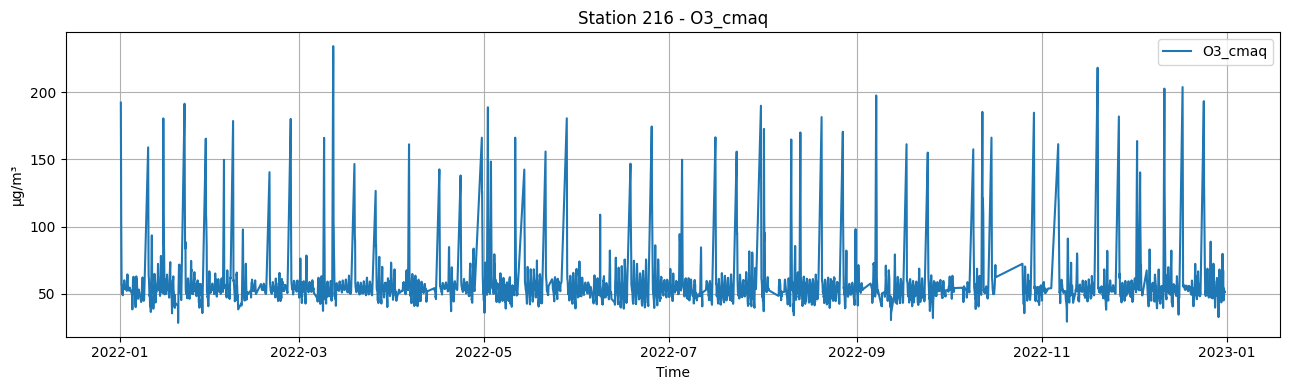

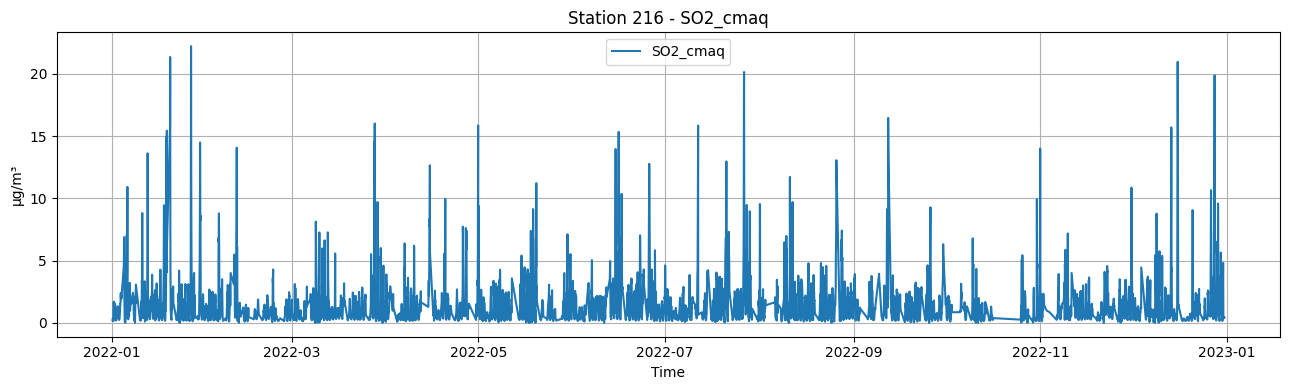

In [9]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, target_col, df_station["date"], f"Station {station} - {target_col}")
            #plot_1_data(df_station, target_col, target_col, df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

Output: df_converted

In [10]:
df_converted = copy.deepcopy(df_dropped)
mask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")
df_converted.loc[mask, "NO2_quantrac"] = df_converted.loc[mask, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[mask, "CO_quantrac"] = df_converted.loc[mask, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted

date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
0    2022-01-01 07:00:00     90.000000      22.783333    35.588975   
1    2022-01-01 08:00:00     90.000000      21.883333    55.011077   
2    2022-01-01 09:00:00     90.000000      16.233333    64.729197   
3    2022-01-01 10:00:00     90.000000      15.700000    75.109218   
4    2022-01-01 11:00:00     74.207348      15.650000    77.767804   
...                  ...           ...            ...          ...   
8228 2022-12-31 01:00:00     92.346548      17.709259    31.425926   
8229 2022-12-31 02:00:00    119.184217      22.803390    43.220339   
8230 2022-12-31 03:00:00    130.034960      23.031667    48.866667   
8231 2022-12-31 04:00:00    121.654720      22.331667    50.633333   
8232 2022-12-31 05:00:00    121.497787      20.108333    52.333333   

      CO_quantrac  Temperature_quantrac  Humid_quantrac  NO2_cmaq     O3_cmaq  \
0      756.627400             24.661667       73.355000  0.136344  188.993157   
1      749.102000             27.258333       65.521667  0.138604  151.741122   
2      727.519000             29.250000       57.910000  0.104141  119.571595   
3      721.196900             30.676667       53.673333  0.075893   95.109490   
4      722.056400             32.168333       49.080000  0.063087   57.721016   
...           ...                   ...             ...       ...         ...   
8228   945.048148             26.659259       64.601852  4.285888   51.784937   
8229   822.974780             25.771186       66.067797  4.157322   51.295325   
8230   855.703933             25.178333       68.278333  4.235773   51.130547   
8231   708.340133             24.950000       68.225000  5.047855   51.640614   
8232   712.736200             24.585000       67.740000  4.876919   51.160312   

      SO2_cmaq  station_id  
0     0.071526         211  
1     0.100084         211  
2     0.130476         211  
3     0.149078         211  
4     0.122092         211  
...        ...         ...  
8228  0.389183         216  
8229  0.386550         216  
8230  0.394695         216  
8231  0.435544         216  
8232  0.429932         216  

[8233 rows x 11 columns]

## Visualization after converting unit

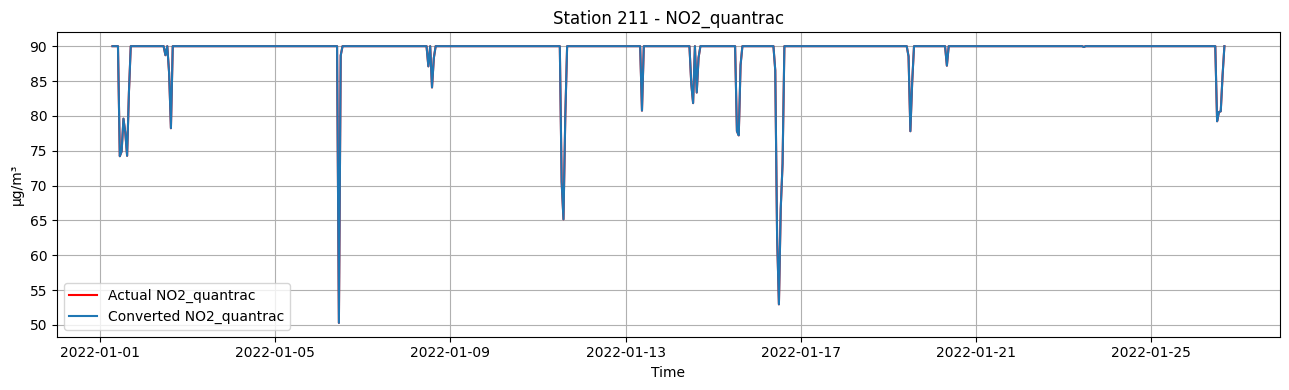

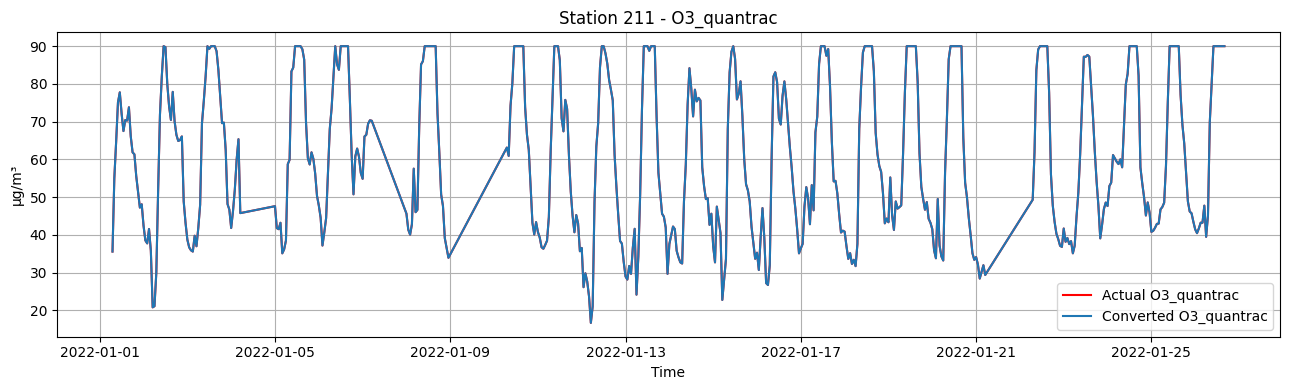

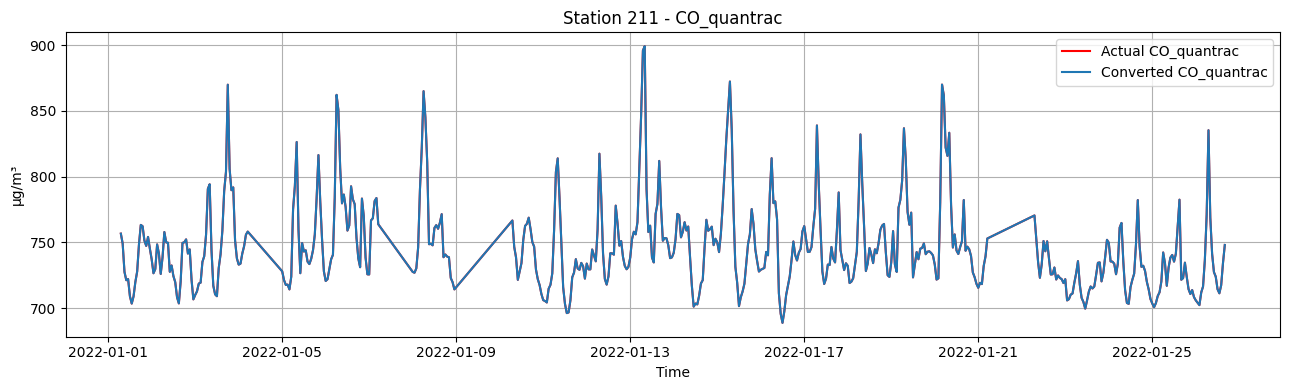

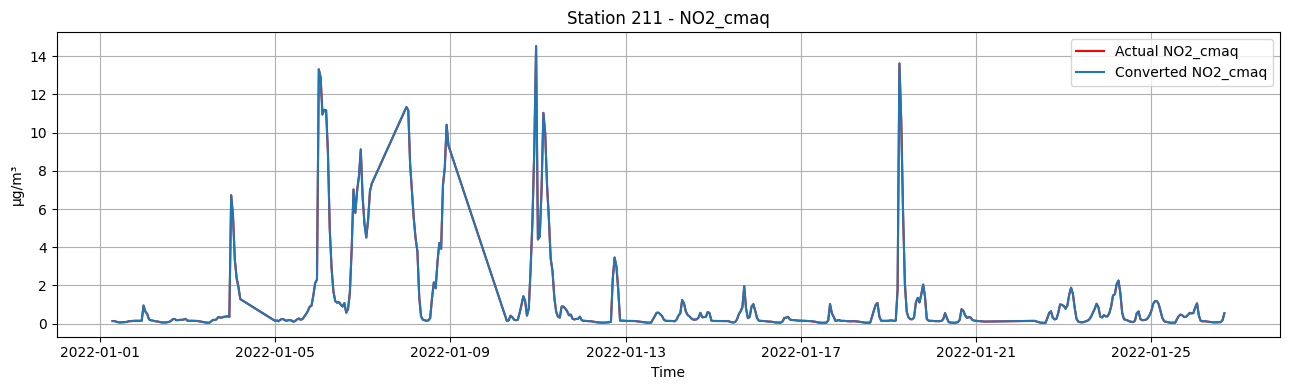

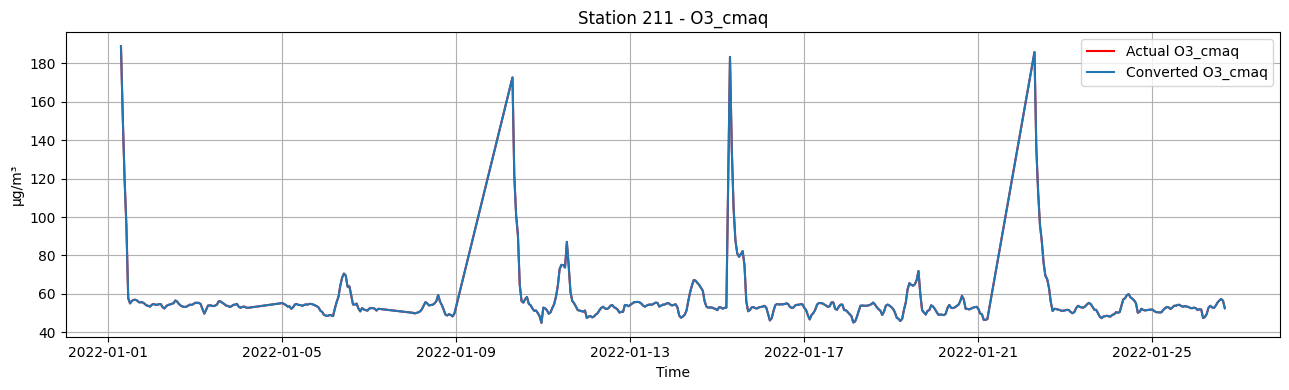

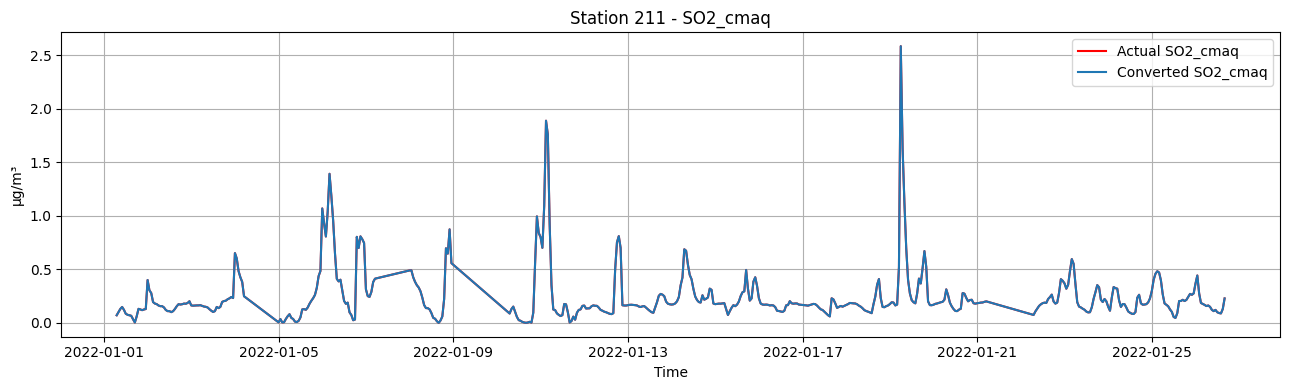

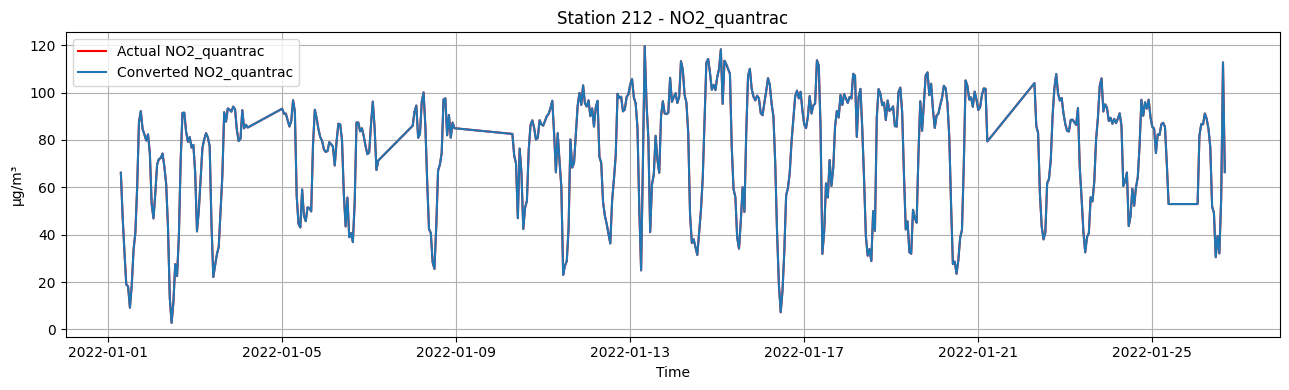

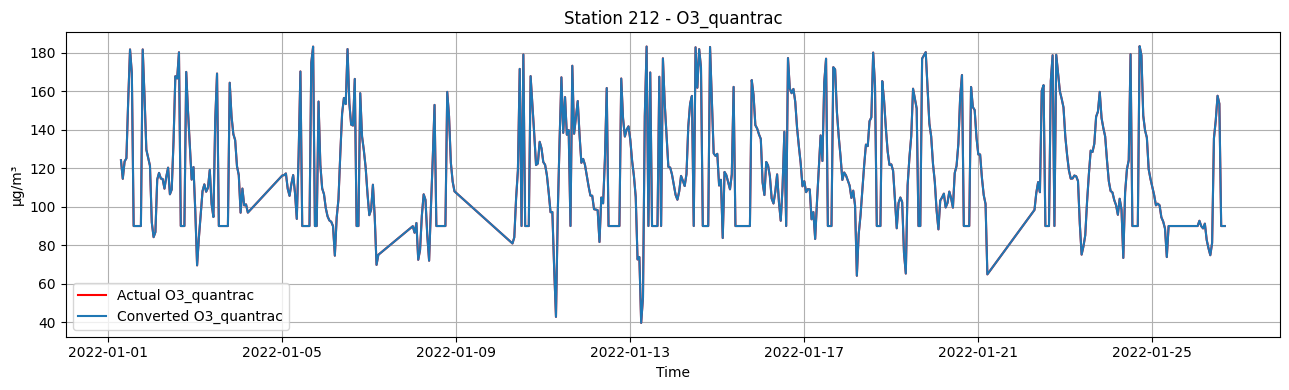

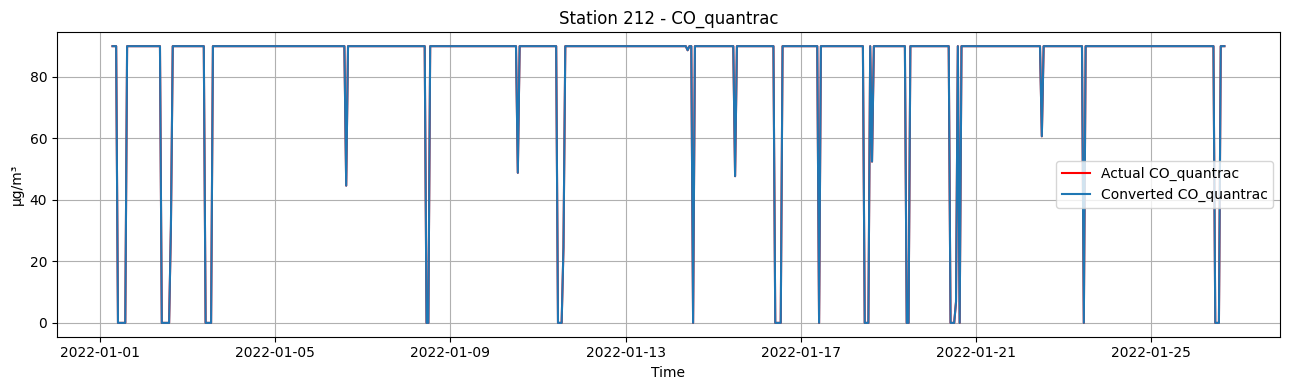

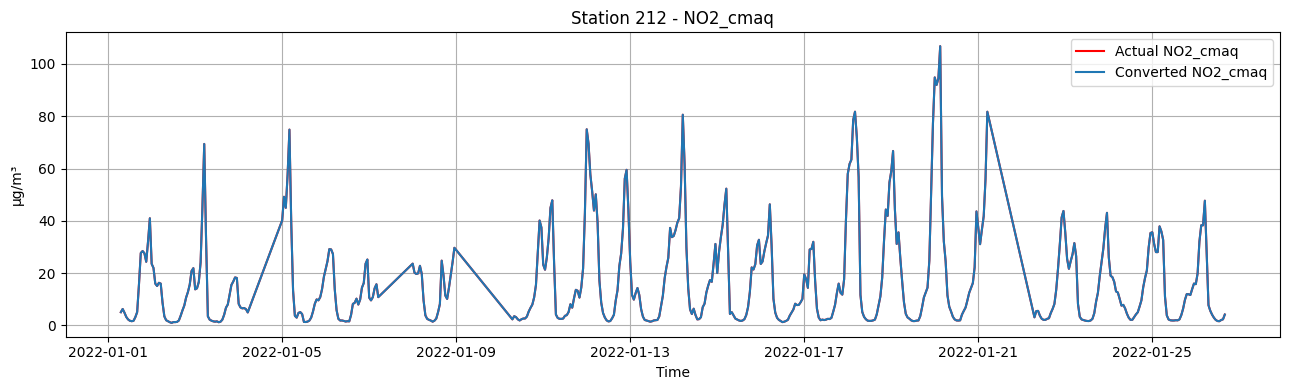

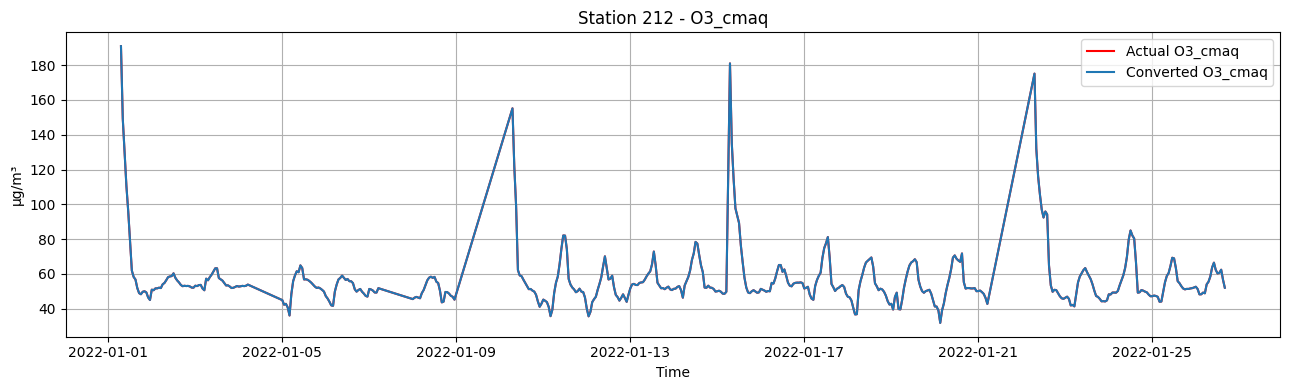

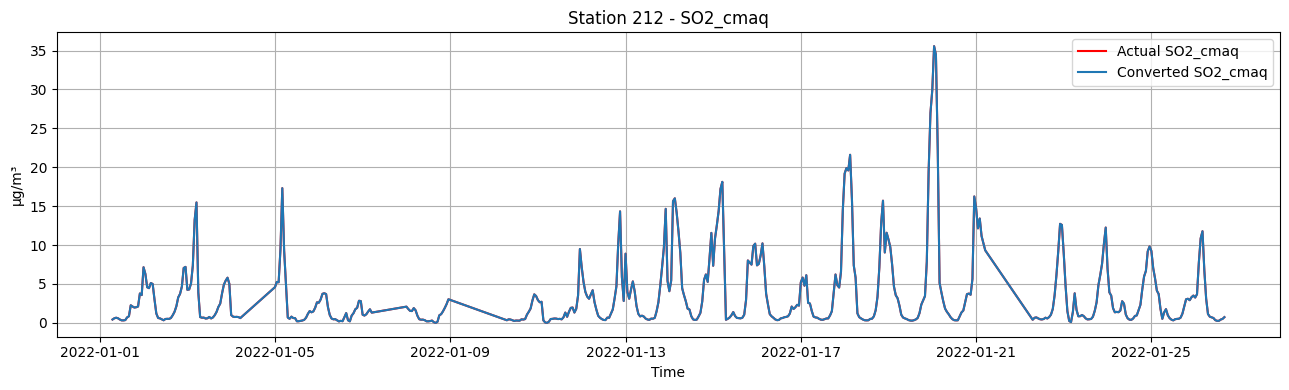

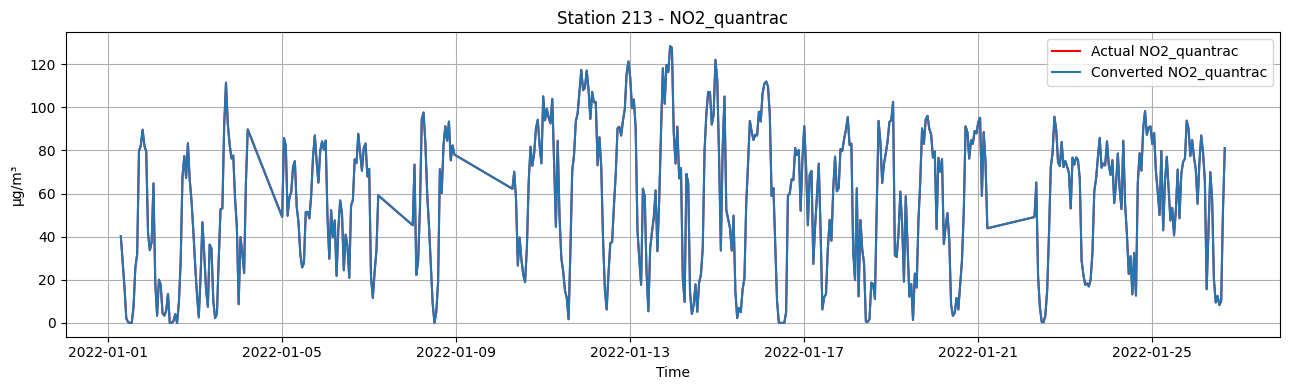

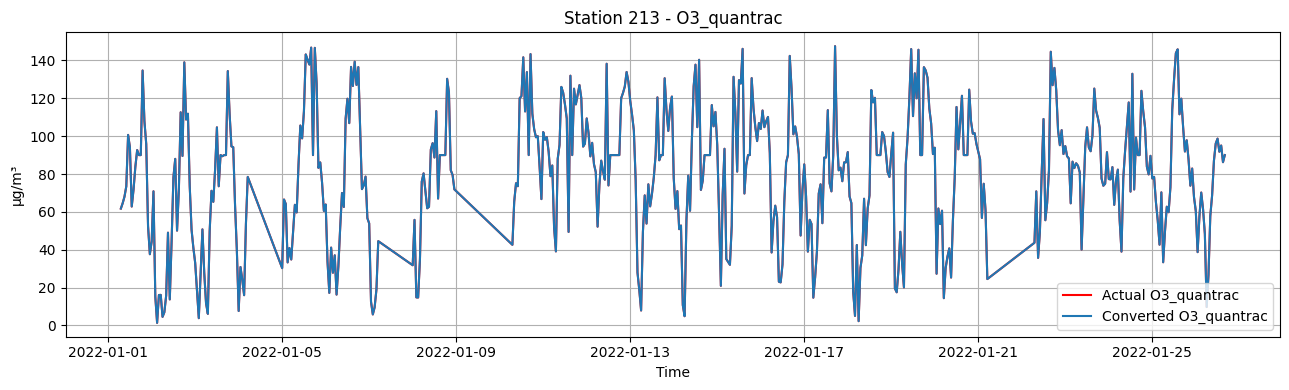

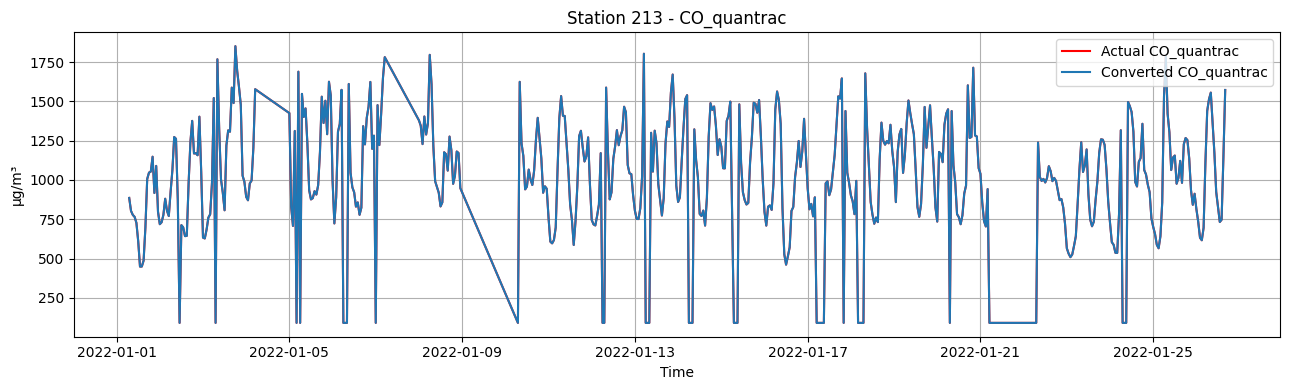

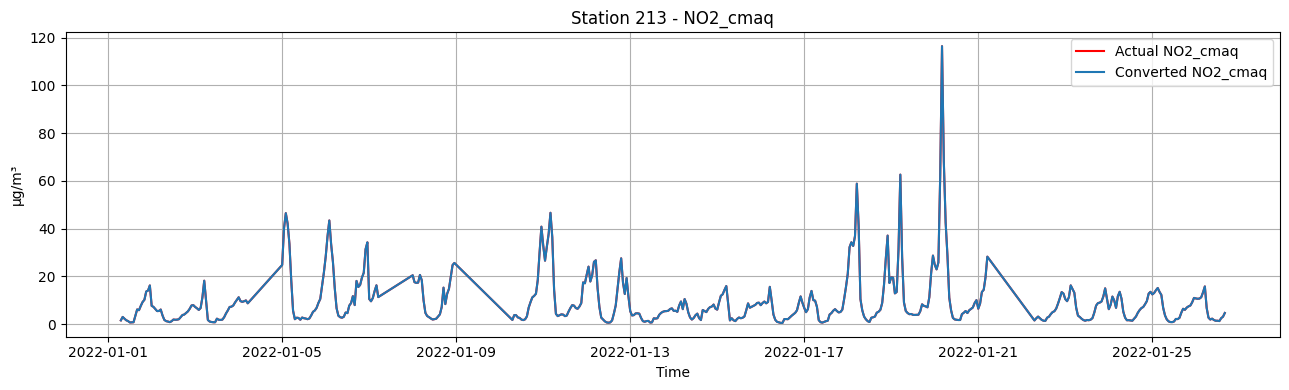

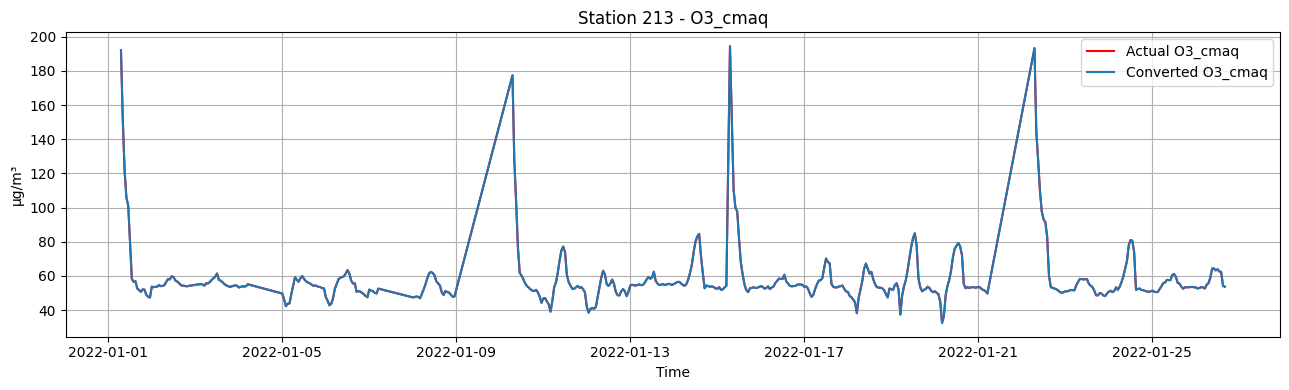

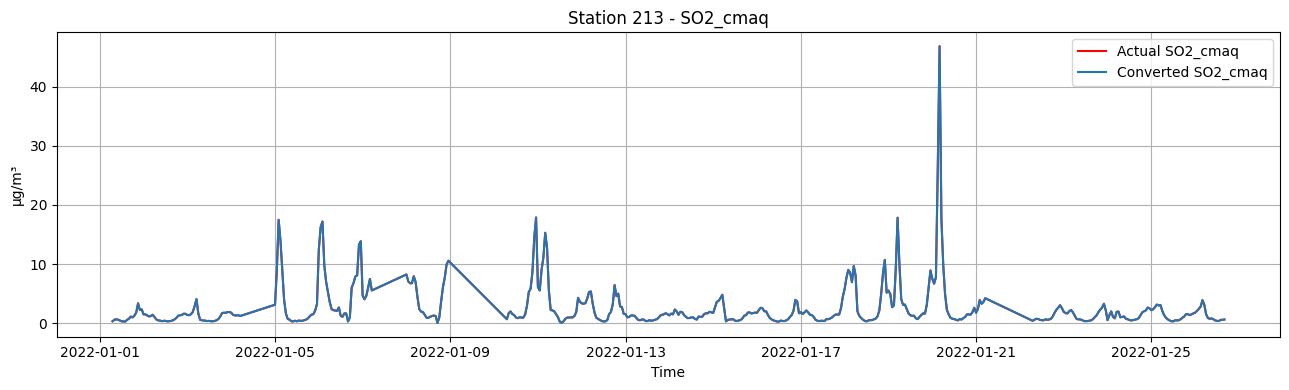

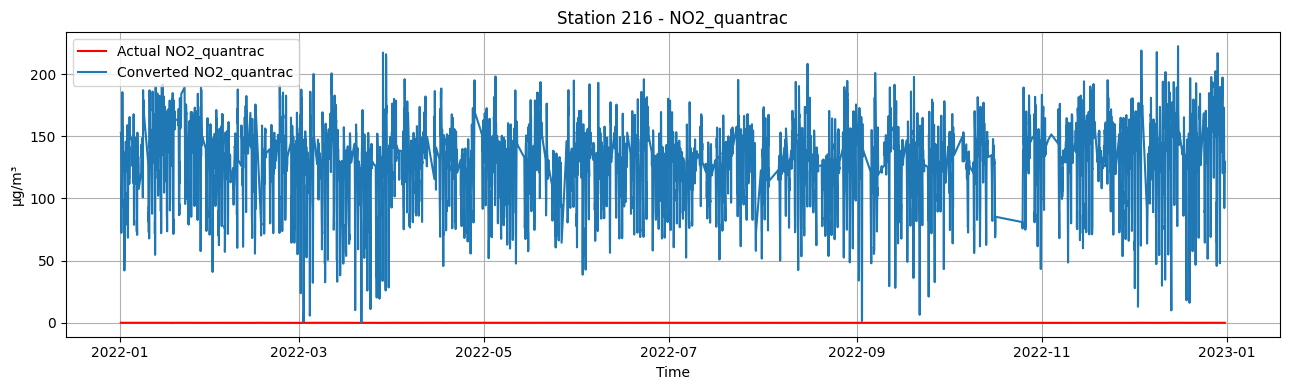

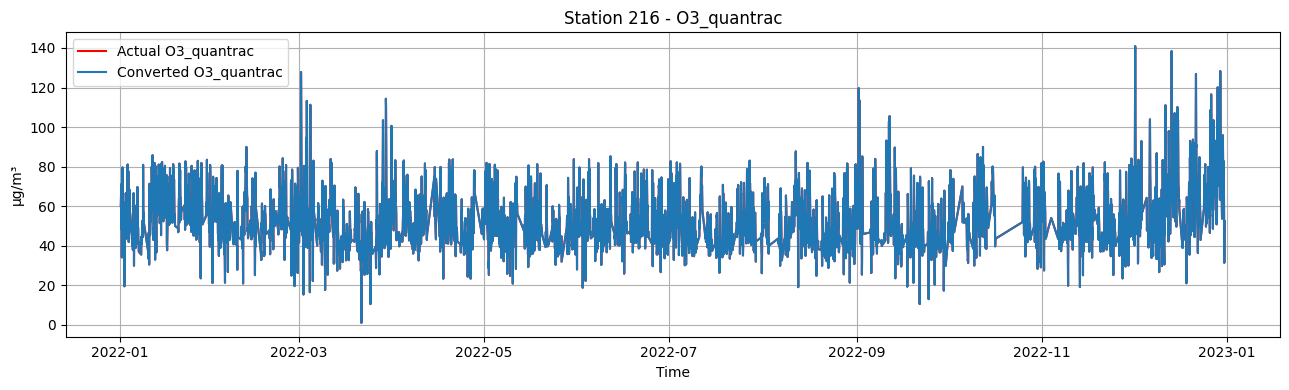

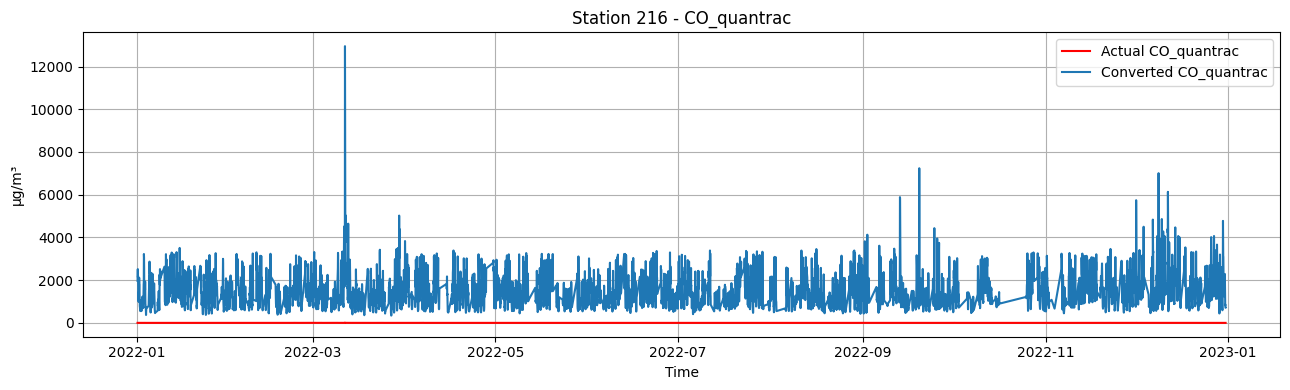

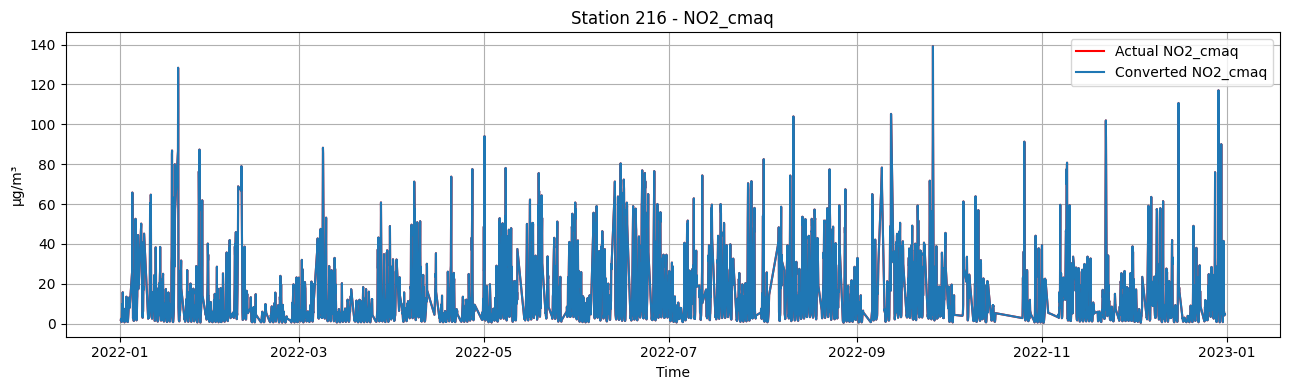

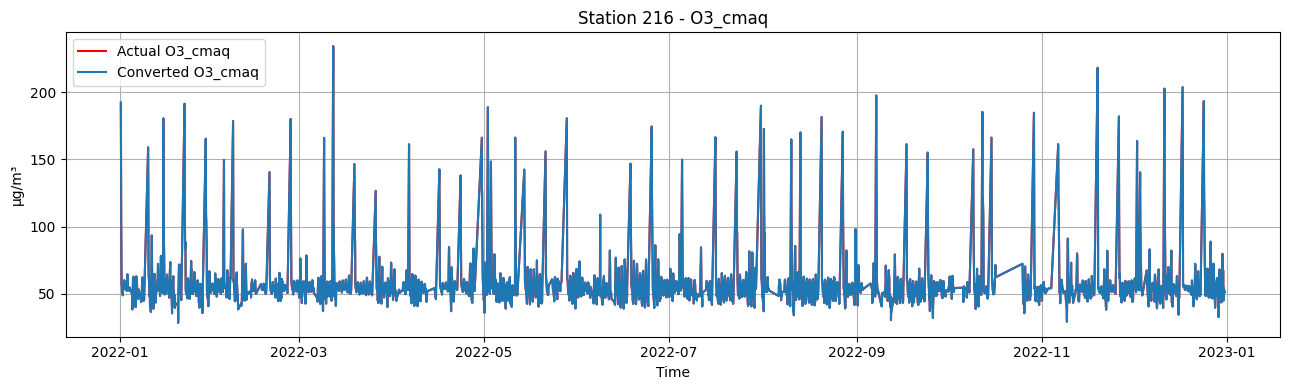

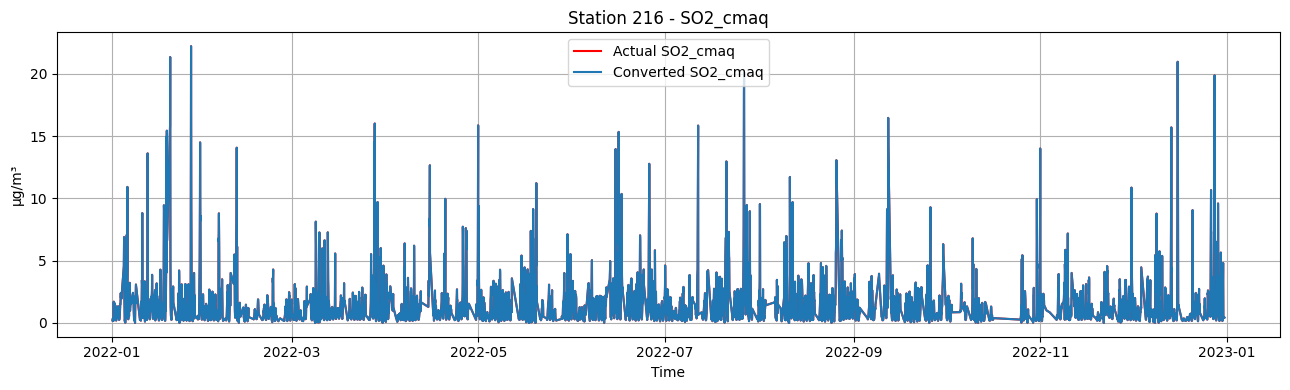

In [11]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_2_data(df_station, target_col, f"Actual {target_col}",
                        df_station_converted, target_col, f"Converted {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Ugly hack to remove outliers

In [12]:
test = copy.deepcopy(df_converted)

lenbefore = len(test)
print(f"Before: {lenbefore} records")

# 212 CO quantrac
test212 = test[test["station_id"] == 212]
test = test.drop(index=test212[test212["CO_quantrac"] > 4000].index)

# 213 CO quantrac
test213 = test[test["station_id"] == 213]
test = test.drop(index=test213[test213["CO_quantrac"] > 4000].index)

# 214 CO quantrac
test214 = test[test["station_id"] == 214]
test = test.drop(index=test214[test214["CO_quantrac"] > 4000].index)

# 215 NO2 quantrac
# 215 CO quantrac
test215 = test[test["station_id"] == 215]
test = test.drop(index=test215[test215["NO2_quantrac"] > 140].index)
test = test.drop(index=test215[test215["CO_quantrac"] > 2500].index)

# 216 CO quantrac
test216 = test[test["station_id"] == 216]
test = test.drop(index=test216[test216["CO_quantrac"] > 10000].index)

# CMAQ

# 211 NO2 cmaq
# 211 O3 cmaq
test211 = test[test["station_id"] == 211]
test = test.drop(index=test211[test211["NO2_cmaq"] > 10].index, errors="ignore")
test = test.drop(index=test211[test211["O3_cmaq"] > 100].index, errors="ignore")
test = test.drop(index=test211[test211["SO2_cmaq"] > 1.5].index, errors="ignore")

# 212 O3 cmaq
# 212 SO2 cmaq
test212 = test[test["station_id"] == 212]
test = test.drop(index=test212[test212["O3_cmaq"] > 100].index, errors="ignore")
test = test.drop(index=test212[test212["SO2_cmaq"] > 25].index, errors="ignore")

# 213 NO2 cmaq
# 213 O3 cmaq
# 213 SO2 cmaq
test213 = test[test["station_id"] == 213]
test = test.drop(index=test213[test213["NO2_cmaq"] > 80].index, errors="ignore")
test = test.drop(index=test213[test213["O3_cmaq"] > 140].index, errors="ignore")
test = test.drop(index=test213[test213["SO2_cmaq"] > 20].index, errors="ignore")

lenafter = len(test)
print(f"After: {lenafter} records")
print(f"Removed {lenbefore - lenafter} records")

df_converted = test.reset_index(drop=True)

Before: 8233 records
After: 8180 records
Removed 53 records


## Visualization after removing outliers

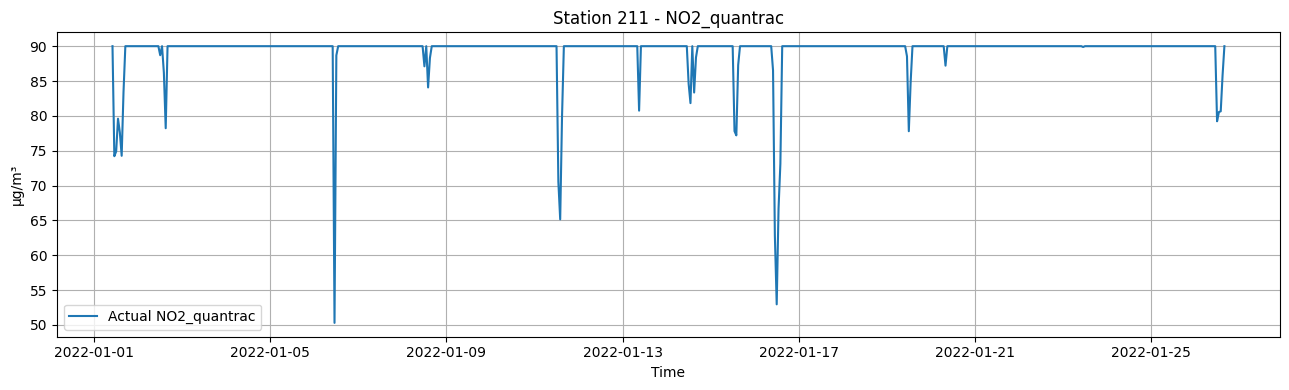

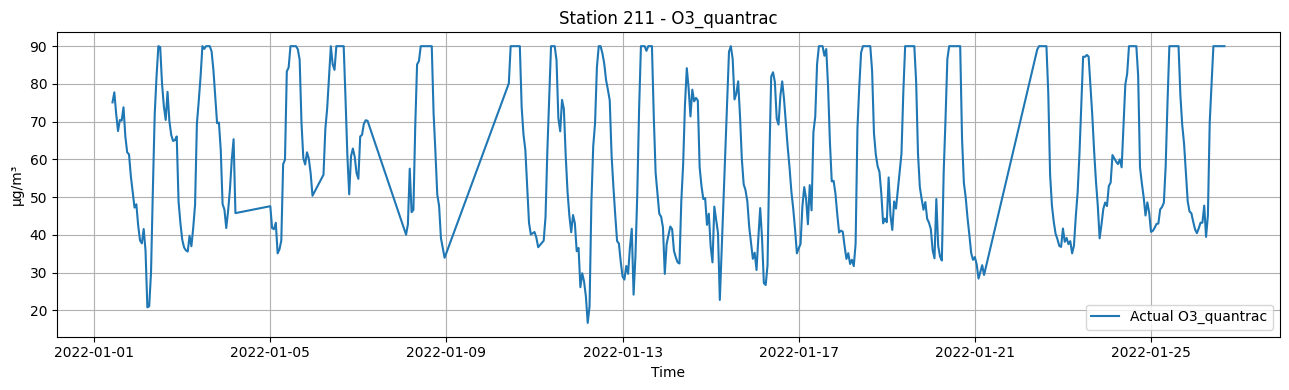

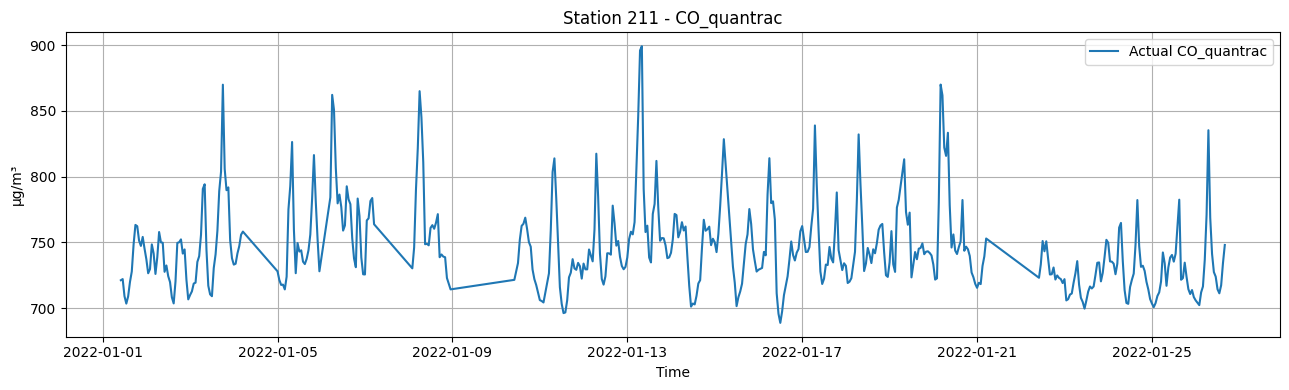

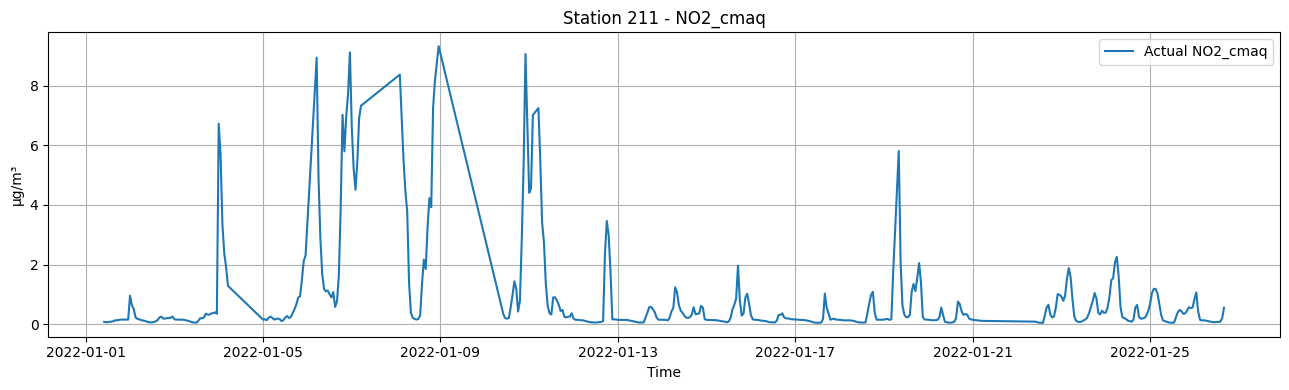

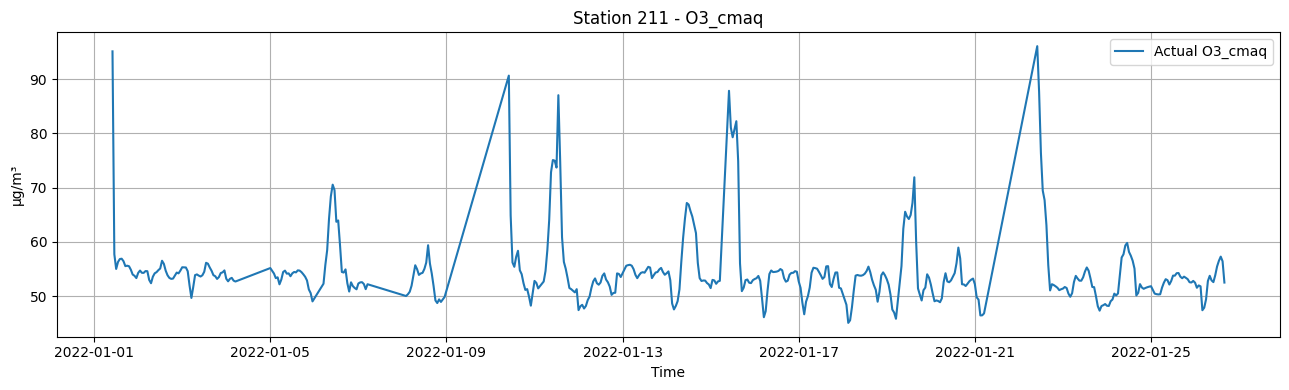

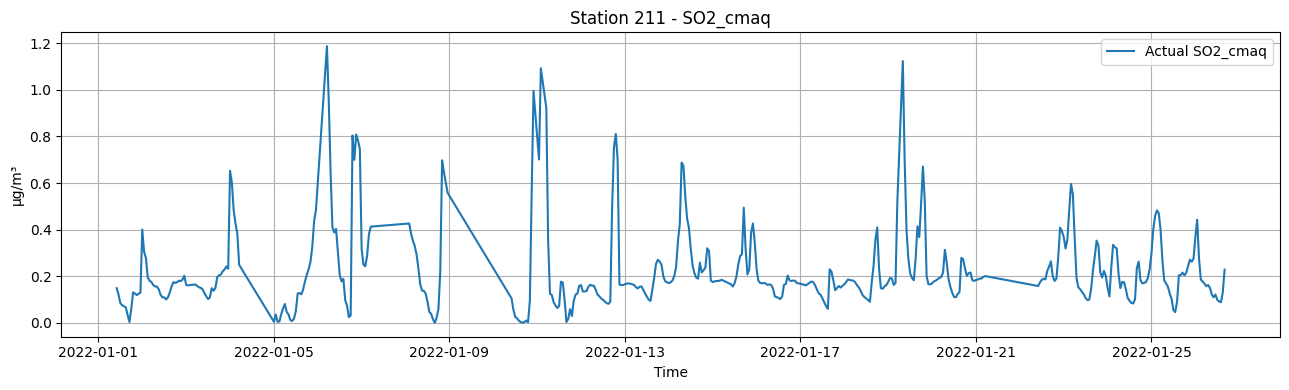

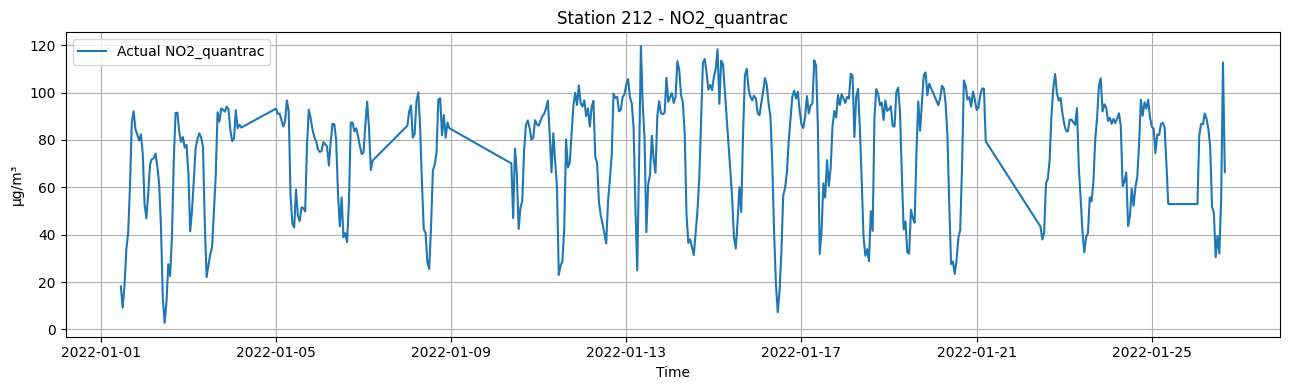

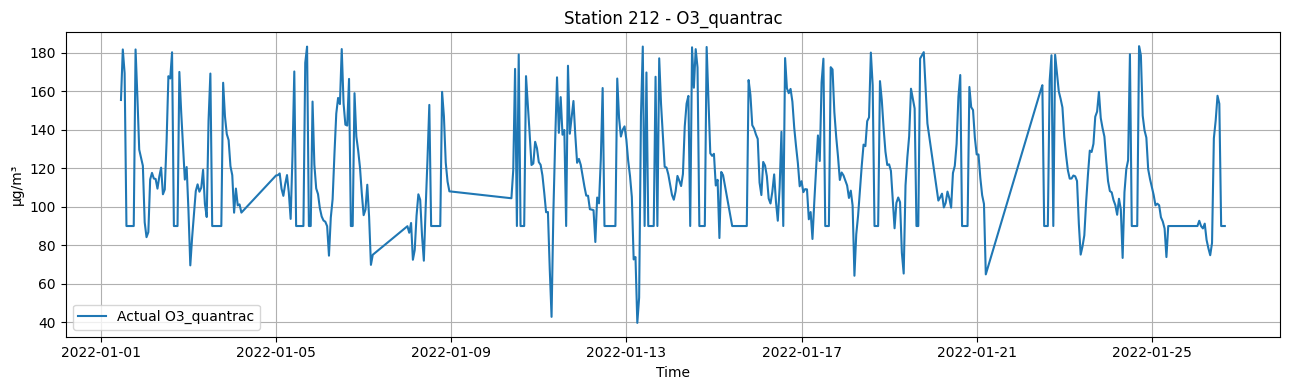

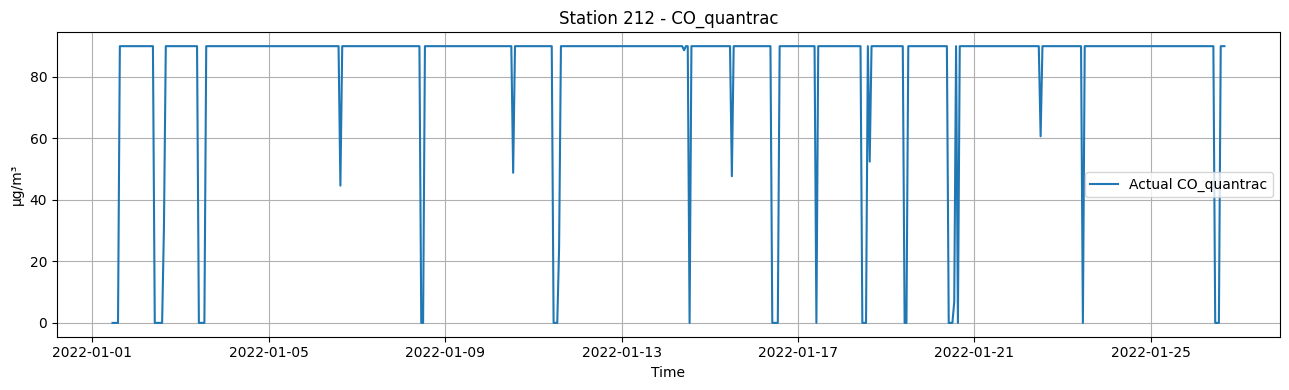

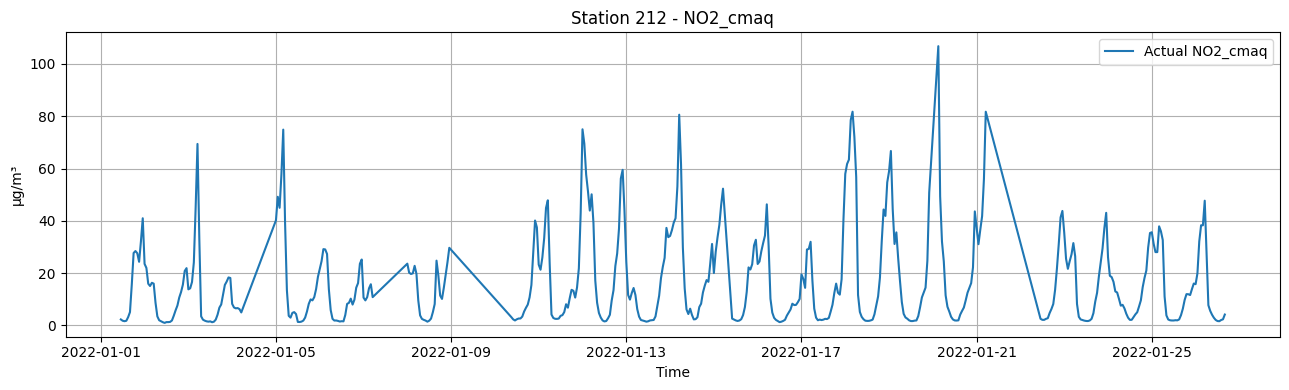

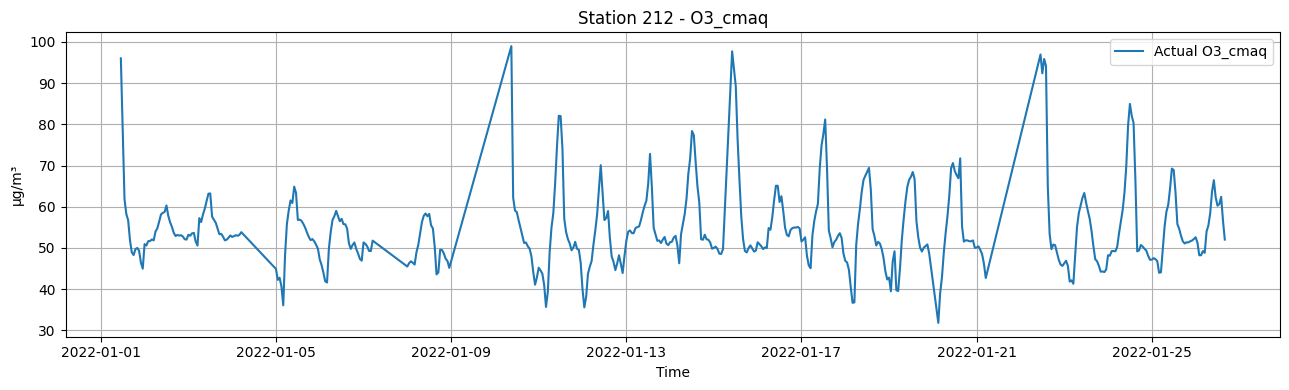

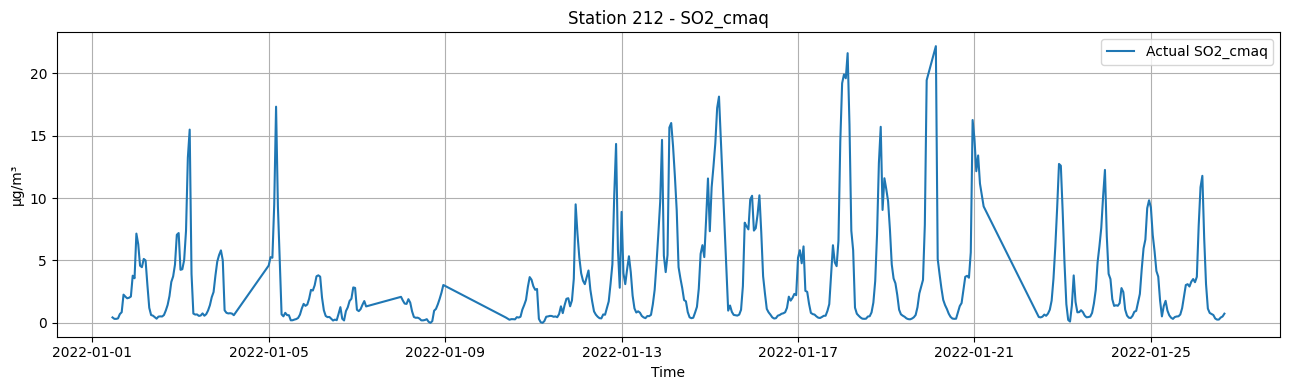

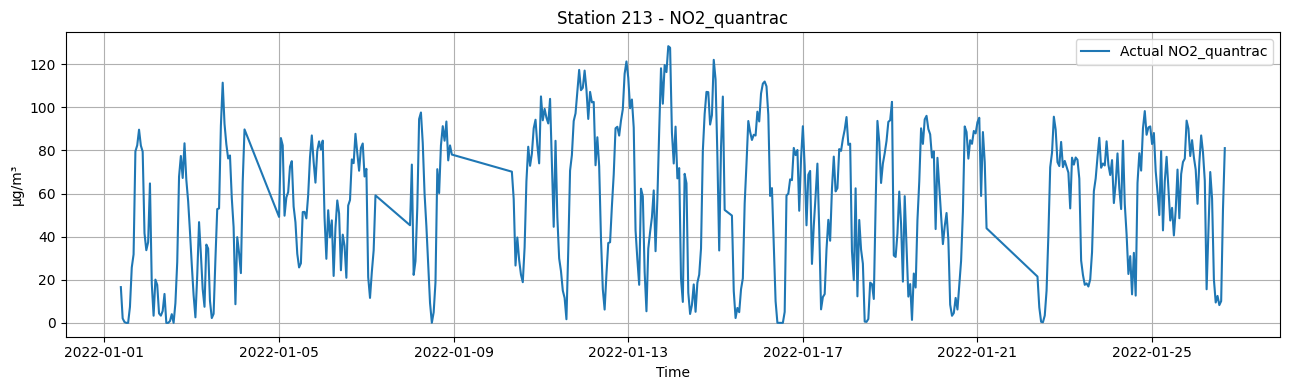

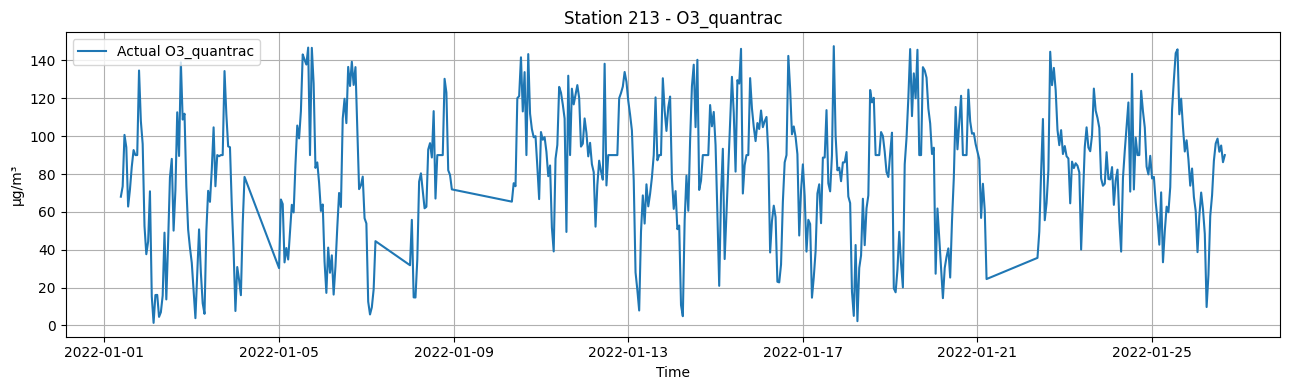

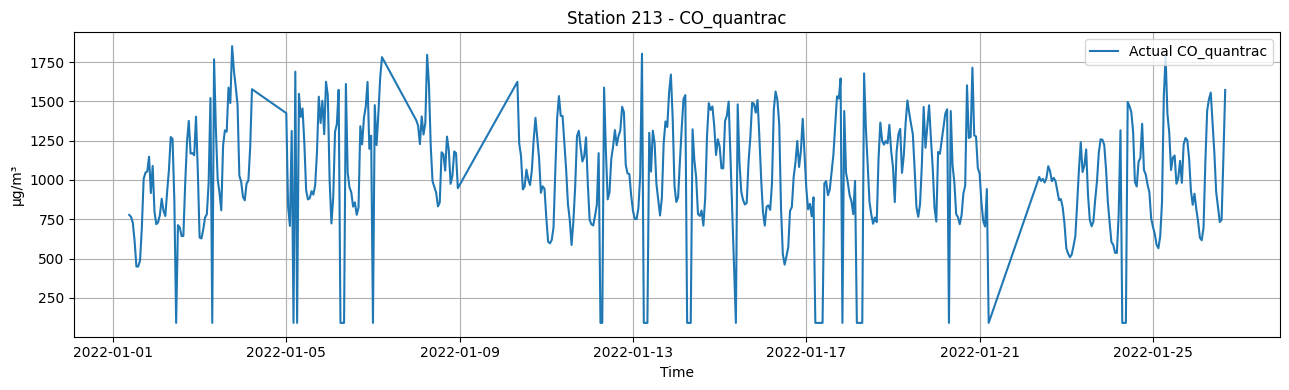

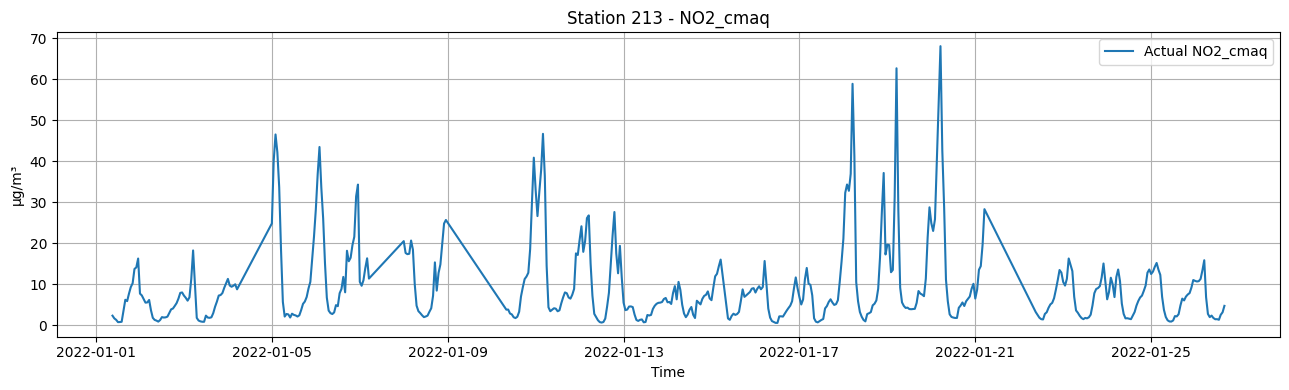

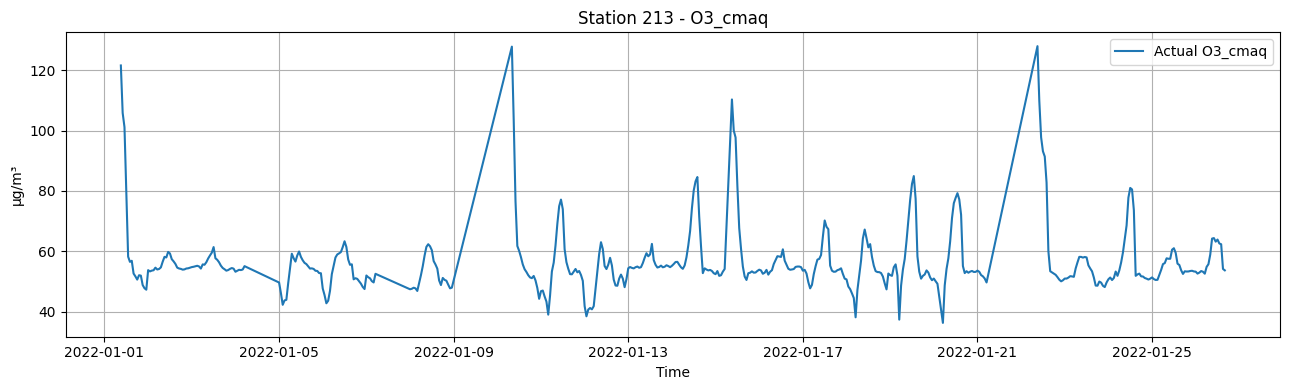

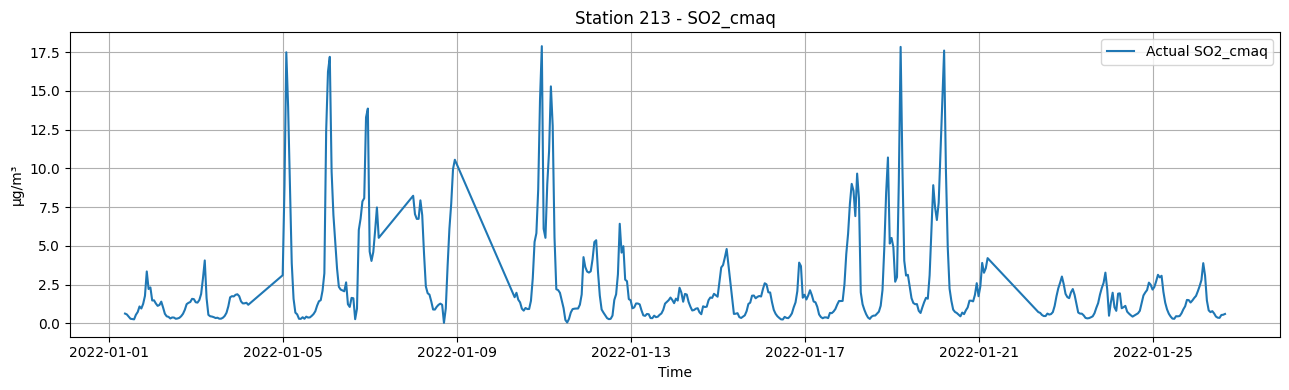

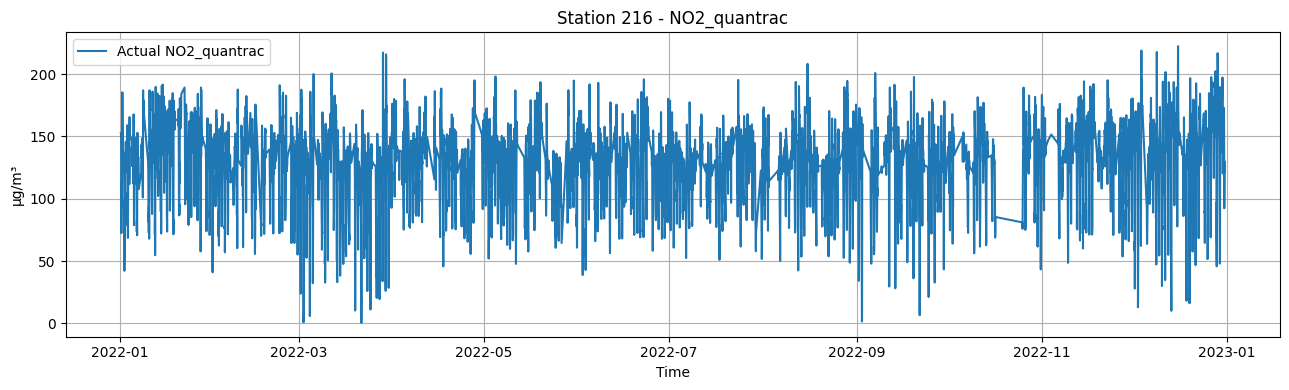

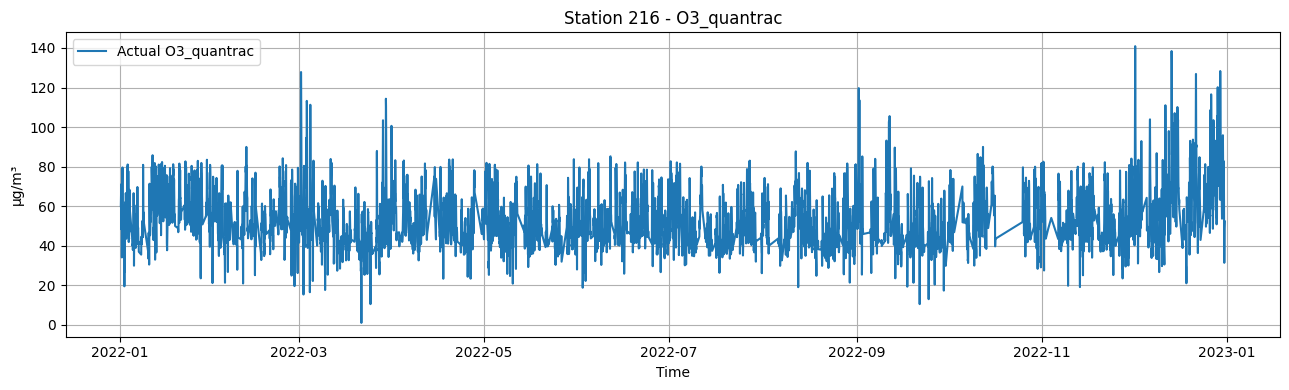

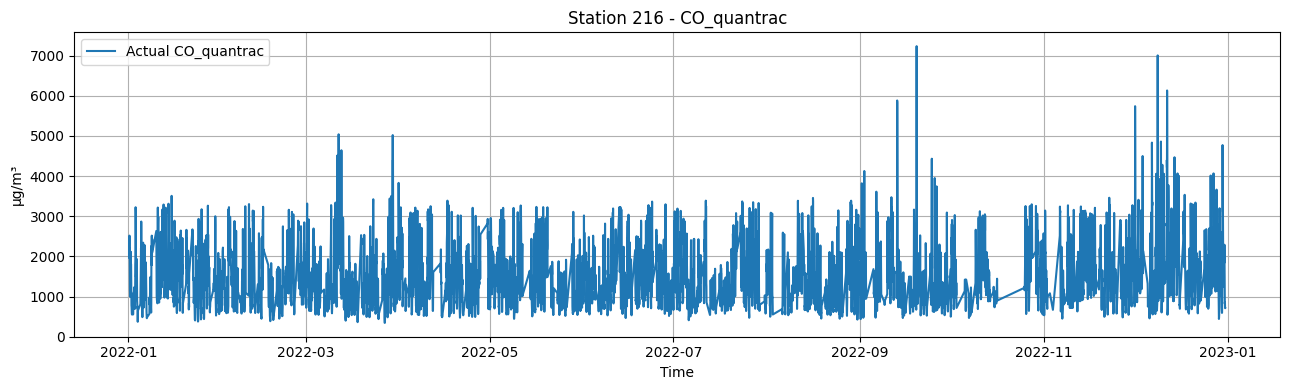

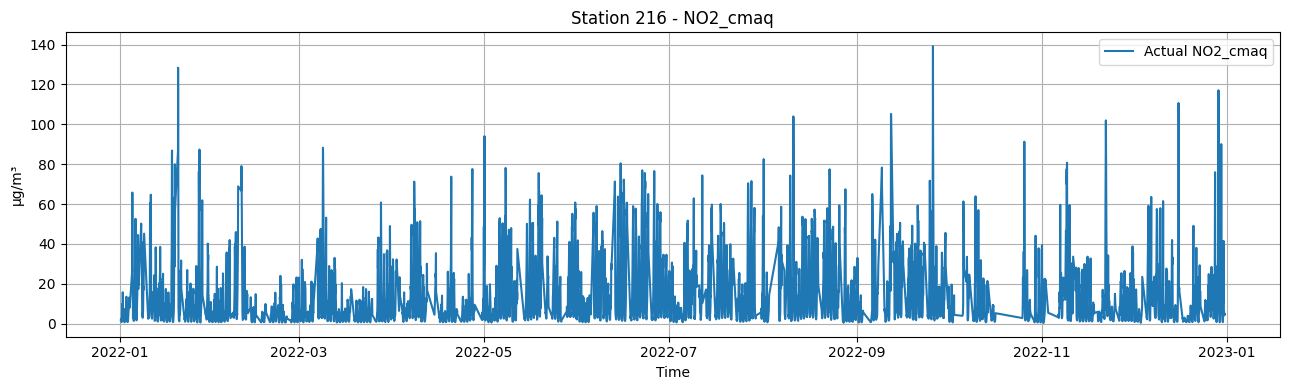

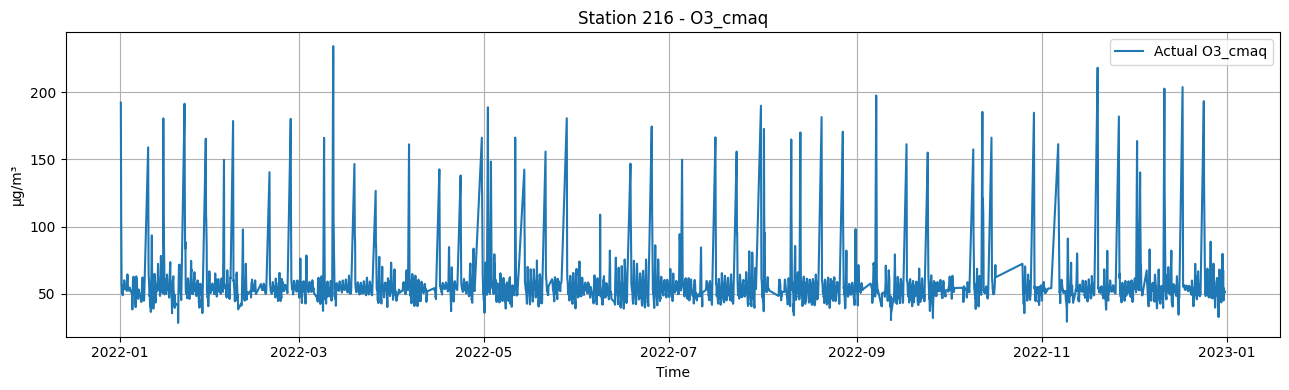

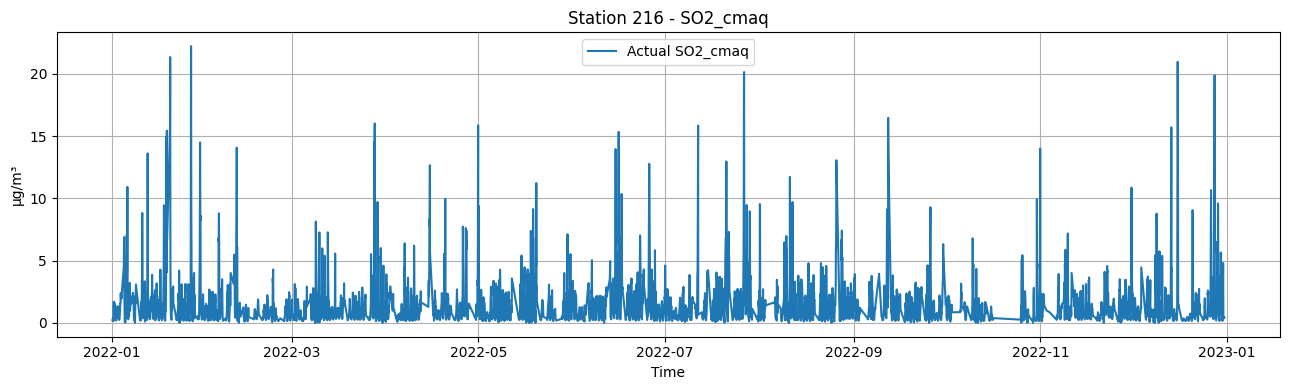

In [13]:
for station in STATION_IDS:
    df_station = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, f"Actual {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

# Prepare test data with 73 records

In [14]:
df_test = df_converted.iloc[0:73]
df_test

date  NO2_quantrac  PM25_quantrac  O3_quantrac  CO_quantrac  \
0  2022-01-01 10:00:00     90.000000      15.700000    75.109218     721.1969   
1  2022-01-01 11:00:00     74.207348      15.650000    77.767804     722.0564   
2  2022-01-01 12:00:00     74.890246      11.833333    72.086817     709.0302   
3  2022-01-01 13:00:00     79.595678       7.900000    67.509674     703.4148   
4  2022-01-01 14:00:00     77.621284       8.366667    70.440426     708.8583   
..                 ...           ...            ...          ...          ...   
68 2022-01-05 00:00:00     90.000000      23.583333    47.606327     727.9774   
69 2022-01-05 01:00:00     90.000000      20.900000    41.799970     721.3688   
70 2022-01-05 02:00:00     90.000000      20.916667    41.512621     717.6061   
71 2022-01-05 03:00:00     90.000000      25.100000    43.211898     717.8544   
72 2022-01-05 04:00:00     90.000000      19.600000    35.113256     714.2063   

    Temperature_quantrac  Humid_quantrac  NO2_cmaq    O3_cmaq  SO2_cmaq  \
0              30.676667       53.673333  0.075893  95.109490  0.149078   
1              32.168333       49.080000  0.063087  57.721016  0.122092   
2              31.860000       49.410000  0.068737  55.009452  0.085674   
3              31.395000       50.456667  0.076458  56.294395  0.075980   
4              31.781667       51.025000  0.082672  56.840809  0.071788   
..                   ...             ...       ...        ...       ...   
68             25.526667       84.528333  0.149526  55.172342  0.005423   
69             25.138333       84.746667  0.167228  54.657936  0.036156   
70             25.065000       85.491667  0.129188  54.169282  0.005214   
71             24.840000       86.205000  0.211598  53.317915  0.006498   
72             24.398333       87.865000  0.251488  53.470748  0.037204   

    station_id  
0          211  
1          211  
2          211  
3          211  
4          211  
..         ...  
68         211  
69         211  
70         211  
71         211  
72         211  

[73 rows x 11 columns]

In [15]:
data = {}
for col in df_test.columns:
    new_col = col.lower()
    data[new_col] = [str(item) for item in df_test[col].to_list()]

for k,v in data.items():
    print(f'"{k}": ', end='')
    if k == "date":
        formatted_items = [f'"{item}"' for item in v]
        print(f"[{', '.join(formatted_items)}],")
    else:
        formatted_items = [f'{item}' for item in v]
        print(f"[{', '.join(formatted_items)}],")
    print("\n")

"date": ["2022-01-01 10:00:00", "2022-01-01 11:00:00", "2022-01-01 12:00:00", "2022-01-01 13:00:00", "2022-01-01 14:00:00", "2022-01-01 15:00:00", "2022-01-01 16:00:00", "2022-01-01 17:00:00", "2022-01-01 18:00:00", "2022-01-01 19:00:00", "2022-01-01 20:00:00", "2022-01-01 21:00:00", "2022-01-01 22:00:00", "2022-01-01 23:00:00", "2022-01-02 00:00:00", "2022-01-02 01:00:00", "2022-01-02 02:00:00", "2022-01-02 03:00:00", "2022-01-02 04:00:00", "2022-01-02 05:00:00", "2022-01-02 06:00:00", "2022-01-02 07:00:00", "2022-01-02 08:00:00", "2022-01-02 09:00:00", "2022-01-02 10:00:00", "2022-01-02 11:00:00", "2022-01-02 12:00:00", "2022-01-02 13:00:00", "2022-01-02 14:00:00", "2022-01-02 15:00:00", "2022-01-02 16:00:00", "2022-01-02 17:00:00", "2022-01-02 18:00:00", "2022-01-02 19:00:00", "2022-01-02 20:00:00", "2022-01-02 21:00:00", "2022-01-02 22:00:00", "2022-01-02 23:00:00", "2022-01-03 00:00:00", "2022-01-03 01:00:00", "2022-01-03 02:00:00", "2022-01-03 03:00:00", "2022-01-03 04:00:00", "2

# LightGBM model

## Add time and lags features

In [16]:
# Add time features and lag feature for all gases
df_time_feats = add_time_features(df_converted)
df_lag_feats = add_lag_features(df_time_feats, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

## Training for NO2

In [17]:
# Add rolling features for target_col
target_col = "NO2_quantrac"
df_no2 = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[target_col], windows=ROLL_WINDOWS)

# Add station embedding
with open(os.path.join(model_path, f"{target_col}_pmcmaq_station_embedding.pkl"), "rb") as no2_emb_file:
    no2_station_to_embedding = pickle.load(no2_emb_file)
print(no2_station_to_embedding)
df_no2, _ = attach_station_embedding(df_no2, no2_station_to_embedding, station_col="station_id")

# Dropna
df_no2 = df_no2.dropna()
display(df_no2)

for horizon_h in HORIZONS:
    test_model = lgb.Booster(model_file=os.path.join(model_path, f"{target_col}_pmcmaq_lightgbm_{horizon_h}h"))
    predicted_value = test_model.predict(df_no2.drop(columns=["station_id", "date", target_col]), num_iteration=getattr(test_model, "best_iteration", None))[0]
    print(f"Horizon: {horizon_h}h - predicted: {predicted_value}")

{211: [0.014593521, -1.2980313, -1.8663046, 0.7495554], 212: [-1.1537478, -3.9342809, -2.7167745, 1.1594019], 213: [-2.5934203, -1.0340245, -3.056799, 1.349287], 216: [-2.6024287, -3.3043966, -3.4912176, 3.5754483]}


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
72   2022-01-05 04:00:00     90.000000      19.600000    35.113256   
73   2022-01-05 05:00:00     90.000000      22.483333    36.164927   
74   2022-01-05 06:00:00     90.000000      26.083013    38.513590   
75   2022-01-05 07:00:00     90.000000      38.600000    58.733391   
76   2022-01-05 08:00:00     90.000000      23.634735    59.903014   
...                  ...           ...            ...          ...   
8175 2022-12-31 01:00:00     92.346548      17.709259    31.425926   
8176 2022-12-31 02:00:00    119.184217      22.803390    43.220339   
8177 2022-12-31 03:00:00    130.034960      23.031667    48.866667   
8178 2022-12-31 04:00:00    121.654720      22.331667    50.633333   
8179 2022-12-31 05:00:00    121.497787      20.108333    52.333333   

      CO_quantrac  Temperature_quantrac  Humid_quantrac  NO2_cmaq    O3_cmaq  \
72     714.206300             24.398333       87.865000  0.251488  53.470748   
73     723.851800             24.071667       90.228333  0.208738  52.177060   
74     775.058900             24.023333       90.730000  0.150656  53.050462   
75     792.841000             25.408333       85.043333  0.175514  54.442465   
76     826.323300             27.106667       79.371667  0.186248  54.704943   
...           ...                   ...             ...       ...        ...   
8175   945.048148             26.659259       64.601852  4.285888  51.784937   
8176   822.974780             25.771186       66.067797  4.157322  51.295325   
8177   855.703933             25.178333       68.278333  4.235773  51.130547   
8178   708.340133             24.950000       68.225000  5.047855  51.640614   
8179   712.736200             24.585000       67.740000  4.876919  51.160312   

      SO2_cmaq  ...  NO2_quantrac_roll24_mean  NO2_quantrac_roll24_std  \
72    0.037204  ...                 90.000000                 0.000000   
73    0.062618  ...                 90.000000                 0.000000   
74    0.081482  ...                 90.000000                 0.000000   
75    0.047160  ...                 90.000000                 0.000000   
76    0.036942  ...                 90.000000                 0.000000   
...        ...  ...                       ...                      ...   
8175  0.389183  ...                157.199778                20.786118   
8176  0.386550  ...                154.467975                24.639817   
8177  0.394695  ...                153.499776                25.572650   
8178  0.435544  ...                152.945279                25.944042   
8179  0.429932  ...                152.270465                26.557121   

      NO2_quantrac_roll48_mean  NO2_quantrac_roll48_std  \
72                   89.648138                 1.780363   
73                   89.648138                 1.780363   
74                   89.648138                 1.780363   
75                   89.675194                 1.775529   
76                   89.675194                 1.775529   
...                        ...                      ...   
8175                153.237924                33.011382   
8176                151.940754                34.159644   
8177                151.240772                34.484712   
8178                150.809173                34.620338   
8179                150.178170                34.874325   

      NO2_quantrac_roll72_mean  NO2_quantrac_roll72_std  station_emb_0  \
72                   88.709504                 3.873700       0.014594   
73                   88.709504                 3.873700       0.014594   
74                   88.928847                 3.466709       0.014594   
75                   89.138705                 3.035418       0.014594   
76                   89.283209                 2.814315       0.014594   
...                        ...                      ...            ...   
8175                154.749098                39.574038      -2.602429   
8176                153.7836

Horizon: 1h - predicted: 90.63124698128318
Horizon: 24h - predicted: 92.26217611507417
Horizon: 48h - predicted: 95.3530272402374
Horizon: 72h - predicted: 95.05923856987998


## Training for O3

In [18]:
# Add rolling features for target_col
target_col = "O3_quantrac"
df_o3 = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[target_col], windows=ROLL_WINDOWS)

# Add station embedding
with open(os.path.join(model_path, f"{target_col}_pmcmaq_station_embedding.pkl"), "rb") as o3_emb_file:
    o3_station_to_embedding = pickle.load(o3_emb_file)
print(o3_station_to_embedding)
df_o3, _ = attach_station_embedding(df_o3, o3_station_to_embedding, station_col="station_id")

# Dropna
df_o3 = df_o3.dropna()
display(df_o3)

for horizon_h in HORIZONS:
    test_model = lgb.Booster(model_file=os.path.join(model_path, f"{target_col}_pmcmaq_lightgbm_{horizon_h}h"))
    predicted_value = test_model.predict(df_o3.drop(columns=["station_id", "date", target_col]), num_iteration=getattr(test_model, "best_iteration", None))[0]
    print(f"Horizon: {horizon_h}h - predicted: {predicted_value}")

{211: [4.1230297, -1.232479, -1.7944901, 0.69273704], 212: [2.8815582, -3.9663625, -2.748144, 1.2045305], 213: [1.4674233, -1.092761, -3.1146529, 1.4212213], 216: [1.3210824, -3.161988, -3.331023, 3.4352763]}


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
72   2022-01-05 04:00:00     90.000000      19.600000    35.113256   
73   2022-01-05 05:00:00     90.000000      22.483333    36.164927   
74   2022-01-05 06:00:00     90.000000      26.083013    38.513590   
75   2022-01-05 07:00:00     90.000000      38.600000    58.733391   
76   2022-01-05 08:00:00     90.000000      23.634735    59.903014   
...                  ...           ...            ...          ...   
8175 2022-12-31 01:00:00     92.346548      17.709259    31.425926   
8176 2022-12-31 02:00:00    119.184217      22.803390    43.220339   
8177 2022-12-31 03:00:00    130.034960      23.031667    48.866667   
8178 2022-12-31 04:00:00    121.654720      22.331667    50.633333   
8179 2022-12-31 05:00:00    121.497787      20.108333    52.333333   

      CO_quantrac  Temperature_quantrac  Humid_quantrac  NO2_cmaq    O3_cmaq  \
72     714.206300             24.398333       87.865000  0.251488  53.470748   
73     723.851800             24.071667       90.228333  0.208738  52.177060   
74     775.058900             24.023333       90.730000  0.150656  53.050462   
75     792.841000             25.408333       85.043333  0.175514  54.442465   
76     826.323300             27.106667       79.371667  0.186248  54.704943   
...           ...                   ...             ...       ...        ...   
8175   945.048148             26.659259       64.601852  4.285888  51.784937   
8176   822.974780             25.771186       66.067797  4.157322  51.295325   
8177   855.703933             25.178333       68.278333  4.235773  51.130547   
8178   708.340133             24.950000       68.225000  5.047855  51.640614   
8179   712.736200             24.585000       67.740000  4.876919  51.160312   

      SO2_cmaq  ...  O3_quantrac_roll24_mean  O3_quantrac_roll24_std  \
72    0.037204  ...                65.094520               19.119510   
73    0.062618  ...                63.142956               19.705568   
74    0.081482  ...                60.899828               19.579127   
75    0.047160  ...                58.784451               19.116389   
76    0.036942  ...                57.481676               17.924836   
...        ...  ...                      ...                     ...   
8175  0.389183  ...                72.275048               13.054325   
8176  0.386550  ...                70.506530               15.478732   
8177  0.394695  ...                69.563733               16.434445   
8178  0.435544  ...                68.868594               16.956151   
8179  0.429932  ...                68.344289               17.328962   

      O3_quantrac_roll48_mean  O3_quantrac_roll48_std  \
72                  62.703834               18.750345   
73                  61.727434               18.944452   
74                  60.605870               18.828262   
75                  59.538611               18.592002   
76                  59.095077               18.345232   
...                       ...                     ...   
8175                76.282513               13.987620   
8176                75.286178               15.403353   
8177                74.575105               16.078964   
8178                74.041960               16.501658   
8179                73.560363               16.844133   

      O3_quantrac_roll72_mean  O3_quantrac_roll72_std  station_emb_0  \
72                  59.727284               18.689222       4.123030   
73                  59.171784               18.819531       4.123030   
74                  58.593967               18.879108       4.123030   
75                  58.127672               18.955612       4.123030   
76                  58.005779               18.922621       4.123030   
...                       ...                     ...            ...   
8175                76.901076               16.456236       1.321082   
8176                76.338936               17.299179       1.321082   
8177                

Horizon: 1h - predicted: 45.709457705948445
Horizon: 24h - predicted: 74.88504932086741
Horizon: 48h - predicted: 56.850714158310296
Horizon: 72h - predicted: 64.19933549888513


## Training for CO

In [19]:
# Add rolling features for target_col
target_col = "CO_quantrac"
df_co = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[target_col], windows=ROLL_WINDOWS)

# Add station embedding
with open(os.path.join(model_path, f"{target_col}_pmcmaq_station_embedding.pkl"), "rb") as co_emb_file:
    co_station_to_embedding = pickle.load(co_emb_file)
print(co_station_to_embedding)
df_co, _ = attach_station_embedding(df_co, co_station_to_embedding, station_col="station_id")

# Dropna
df_co = df_co.dropna()
display(df_co)

for horizon_h in HORIZONS:
    test_model = lgb.Booster(model_file=os.path.join(model_path, f"{target_col}_pmcmaq_lightgbm_{horizon_h}h"))
    predicted_value = test_model.predict(df_co.drop(columns=["station_id", "date", target_col]), num_iteration=getattr(test_model, "best_iteration", None))[0]
    print(f"Horizon: {horizon_h}h - predicted: {predicted_value}")

{211: [-0.055360876, -1.3425553, -1.9094042, 0.7907378], 212: [-1.2046578, -3.949267, -2.7311485, 1.1712998], 213: [-2.7475128, -1.1678884, -3.1978402, 1.4862558], 216: [-2.72049, -3.3912082, -3.586258, 3.665666]}


date  NO2_quantrac  PM25_quantrac  O3_quantrac  \
72   2022-01-05 04:00:00     90.000000      19.600000    35.113256   
73   2022-01-05 05:00:00     90.000000      22.483333    36.164927   
74   2022-01-05 06:00:00     90.000000      26.083013    38.513590   
75   2022-01-05 07:00:00     90.000000      38.600000    58.733391   
76   2022-01-05 08:00:00     90.000000      23.634735    59.903014   
...                  ...           ...            ...          ...   
8175 2022-12-31 01:00:00     92.346548      17.709259    31.425926   
8176 2022-12-31 02:00:00    119.184217      22.803390    43.220339   
8177 2022-12-31 03:00:00    130.034960      23.031667    48.866667   
8178 2022-12-31 04:00:00    121.654720      22.331667    50.633333   
8179 2022-12-31 05:00:00    121.497787      20.108333    52.333333   

      CO_quantrac  Temperature_quantrac  Humid_quantrac  NO2_cmaq    O3_cmaq  \
72     714.206300             24.398333       87.865000  0.251488  53.470748   
73     723.851800             24.071667       90.228333  0.208738  52.177060   
74     775.058900             24.023333       90.730000  0.150656  53.050462   
75     792.841000             25.408333       85.043333  0.175514  54.442465   
76     826.323300             27.106667       79.371667  0.186248  54.704943   
...           ...                   ...             ...       ...        ...   
8175   945.048148             26.659259       64.601852  4.285888  51.784937   
8176   822.974780             25.771186       66.067797  4.157322  51.295325   
8177   855.703933             25.178333       68.278333  4.235773  51.130547   
8178   708.340133             24.950000       68.225000  5.047855  51.640614   
8179   712.736200             24.585000       67.740000  4.876919  51.160312   

      SO2_cmaq  ...  CO_quantrac_roll24_mean  CO_quantrac_roll24_std  \
72    0.037204  ...               752.519308               38.571723   
73    0.062618  ...               752.402321               38.688174   
74    0.081482  ...               752.960200               38.149906   
75    0.047160  ...               755.711396               37.213486   
76    0.036942  ...               758.309792               37.550731   
...        ...  ...                      ...                     ...   
8175  0.389183  ...              1930.118692             1051.387077   
8176  0.386550  ...              1939.356804             1041.247690   
8177  0.394695  ...              1948.144078             1030.392870   
8178  0.435544  ...              1959.166100             1016.568473   
8179  0.429932  ...              1963.809047             1010.311371   

      CO_quantrac_roll48_mean  CO_quantrac_roll48_std  \
72                 743.392294               32.995309   
73                 743.113752               33.187540   
74                 742.935088               33.269276   
75                 743.992750               33.470326   
76                 745.515179               34.002575   
...                       ...                     ...   
8175              1740.859355              948.643557   
8176              1745.153661              944.468857   
8177              1747.963969              941.452442   
8178              1756.607016              931.043799   
8179              1761.516753              924.729049   

      CO_quantrac_roll72_mean  CO_quantrac_roll72_std  station_emb_0  \
72                 741.285856               28.753971      -0.055361   
73                 741.188764               28.834449      -0.055361   
74                 741.213700               28.818442      -0.055361   
75                 742.130765               28.830455      -0.055361   
76                 743.372796               29.064374      -0.055361   
...                       ...                     ...            ...   
8175              1877.187277              880.859623      -2.720490   
8176              1872.938395              884.652423      -2.720490   
8177              18

Horizon: 1h - predicted: 731.5387309192747
Horizon: 24h - predicted: 806.8866602713788
Horizon: 48h - predicted: 883.4136271902506
Horizon: 72h - predicted: 817.7300373716724
